In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH =50

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss(reduction="none")(air_pr.float(), air_x.float())
        air_loss = torch.where(air_x == 1, air_loss, air_loss * 10.0)
        air_loss = air_loss.mean()
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss(reduction="none")(bone_pr.float(), bone_x.float())
        bone_loss = torch.where(bone_x == 1, bone_loss * 10.0, bone_loss)
        bone_loss = bone_loss.mean()
        
        _loss = _gen + air_loss + bone_loss + _mae + _ssim + _dis
        _loss.backward()    
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f56a2610df0>,)

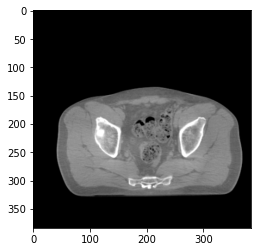

In [22]:
plt.imshow(x.squeeze(), 'gray'),

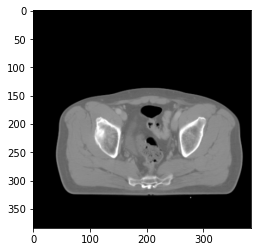

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [04:13,  1.51s/it]
168it [01:16,  2.21it/s]
24it [00:09,  2.52it/s]
168it [04:10,  1.49s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.06it/s]
168it [04:12,  1.50s/it]
168it [01:16,  2.20it/s]
24it [00:12,  1.99it/s]
168it [04:09,  1.49s/it]
168it [01:16,  2.20it/s]
24it [00:11,  2.06it/s]
168it [04:12,  1.50s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.05it/s]
168it [04:11,  1.50s/it]
168it [01:15,  2.22it/s]
24it [00:11,  2.06it/s]
168it [04:12,  1.50s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.05it/s]
168it [04:11,  1.50s/it]
168it [01:15,  2.24it/s]
24it [00:12,  1.90it/s]
168it [04:11,  1.50s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.07it/s]
168it [04:11,  1.50s/it]
168it [01:13,  2.28it/s]
24it [00:11,  2.03it/s]
168it [04:11,  1.50s/it]
168it [01:15,  2.23it/s]
24it [00:11,  2.06it/s]
168it [04:19,  1.54s/it]
168it [01:14,  2.26it/s]
24it [00:11,  2.00it/s]
168it [04:13,  1.51s/it]
168it [01:16,  2.19it/s]
24it [00:11,  2.06it/s]
168it [04:12,  1.50s/it]
168it [01:15,

KeyboardInterrupt: 

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.909504771232605
psnr score = 27.475168228149414
snr score = 17.53810691833496
mae error = 0.013263550586998463
air dice score = 0.9929445245953548
bone dice score = 0.9565217391310566


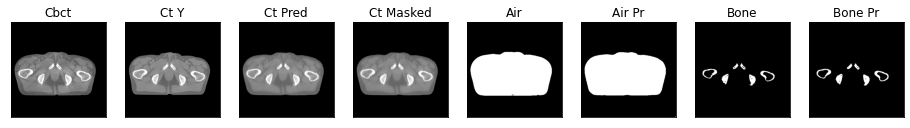

ssim score = 0.9134963154792786
psnr score = 27.746543884277344
snr score = 17.857017517089844
mae error = 0.013195650652050972
air dice score = 0.9921421723187094
bone dice score = 0.956410982168746


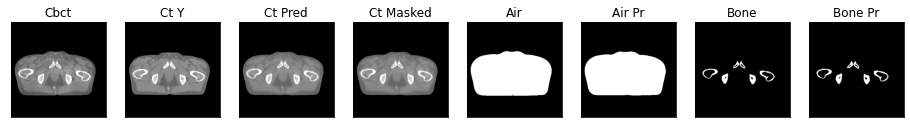

ssim score = 0.9096602201461792
psnr score = 27.29358673095703
snr score = 17.56695556640625
mae error = 0.014499206095933914
air dice score = 0.9927665125103831
bone dice score = 0.9491525423734839


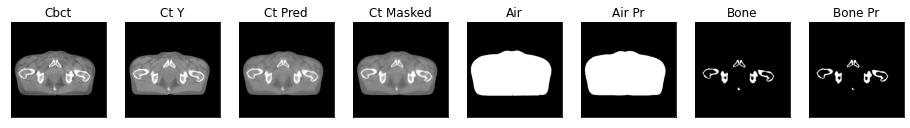

ssim score = 0.9087682962417603
psnr score = 27.505172729492188
snr score = 17.867795944213867
mae error = 0.014403856359422207
air dice score = 0.9930449600729259
bone dice score = 0.9380891173956931


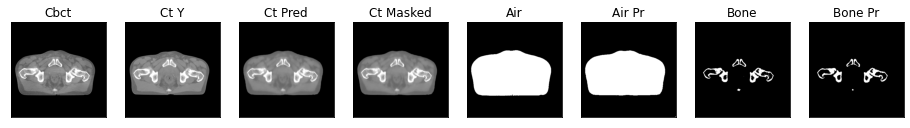

ssim score = 0.9047869443893433
psnr score = 27.24886131286621
snr score = 17.651784896850586
mae error = 0.014824618585407734
air dice score = 0.9946184244494364
bone dice score = 0.9329474191998751


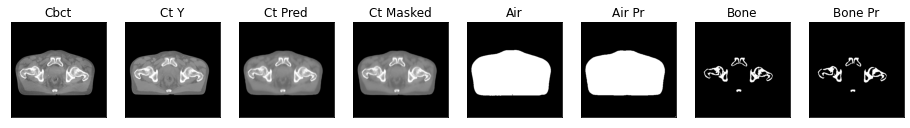

ssim score = 0.9008395075798035
psnr score = 27.095449447631836
snr score = 17.63490867614746
mae error = 0.015350300818681717
air dice score = 0.9945419531226668
bone dice score = 0.9274020175299537


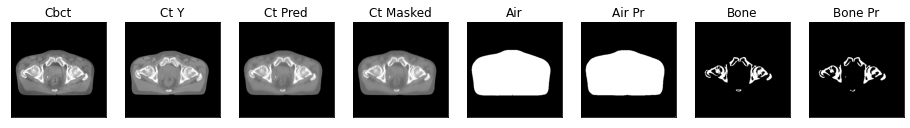

ssim score = 0.8997742533683777
psnr score = 27.188051223754883
snr score = 17.70345115661621
mae error = 0.015579630620777607
air dice score = 0.9931453152954016
bone dice score = 0.9310099009906455


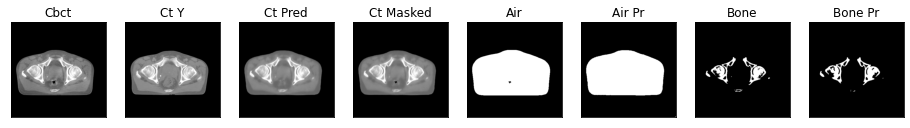

ssim score = 0.9005815982818604
psnr score = 27.51752471923828
snr score = 17.847389221191406
mae error = 0.01486191339790821
air dice score = 0.9936733167586425
bone dice score = 0.9408606805789171


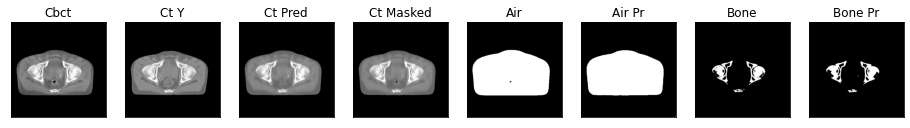

1it [00:03,  3.05s/it]

ssim score = 0.9048843383789062
psnr score = 27.741567611694336
snr score = 17.976877212524414
mae error = 0.014295339584350586
air dice score = 0.9920845939916343
bone dice score = 0.9468516945157477


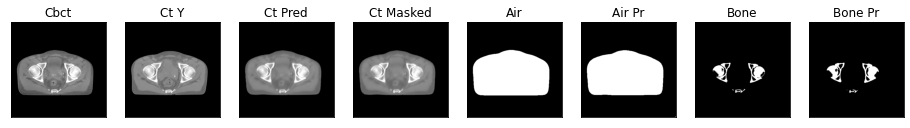

ssim score = 0.9063178300857544
psnr score = 27.80188751220703
snr score = 18.02191734313965
mae error = 0.013963311910629272
air dice score = 0.9920703221047537
bone dice score = 0.938699202991846


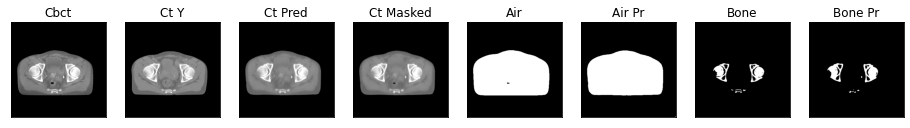

ssim score = 0.9116235375404358
psnr score = 28.2796630859375
snr score = 18.53196144104004
mae error = 0.013261090032756329
air dice score = 0.9936301799808662
bone dice score = 0.9546638874418483


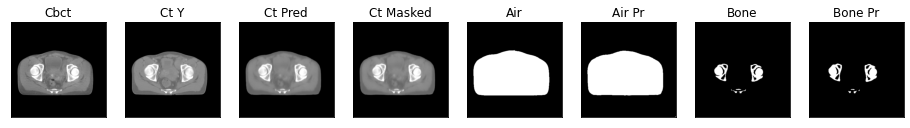

ssim score = 0.9119911789894104
psnr score = 28.171161651611328
snr score = 18.44717025756836
mae error = 0.013478046283125877
air dice score = 0.9914533460565164
bone dice score = 0.9617714643831025


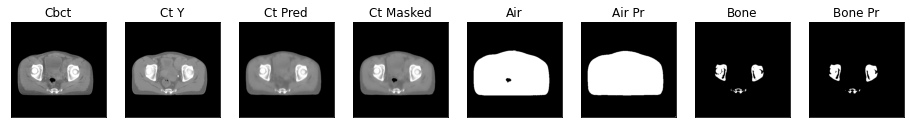

ssim score = 0.9191694855690002
psnr score = 28.53461265563965
snr score = 18.778696060180664
mae error = 0.01303801778703928
air dice score = 0.9886248286399097
bone dice score = 0.9652754213328212


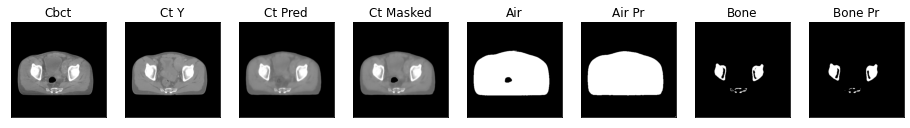

ssim score = 0.9167560935020447
psnr score = 28.33591079711914
snr score = 18.438037872314453
mae error = 0.01352138351649046
air dice score = 0.9886343287512628
bone dice score = 0.9483486466358536


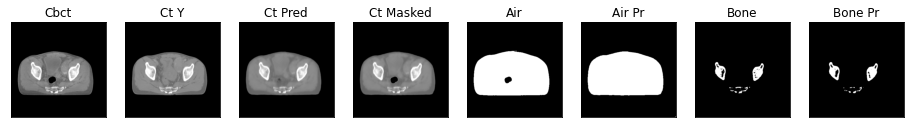

ssim score = 0.915078341960907
psnr score = 28.092954635620117
snr score = 18.109420776367188
mae error = 0.013697633519768715
air dice score = 0.9873708381171202
bone dice score = 0.9302202175652664


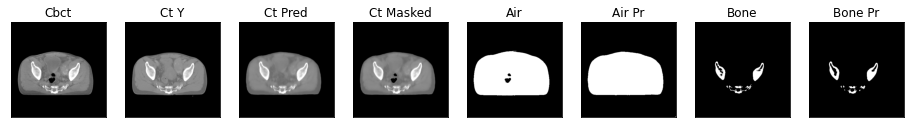

ssim score = 0.9077578186988831
psnr score = 27.31015968322754
snr score = 17.350109100341797
mae error = 0.014585316181182861
air dice score = 0.9898028987985914
bone dice score = 0.9376420095943241


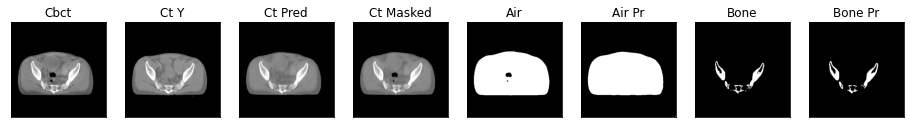

2it [00:05,  2.84s/it]

ssim score = 0.9042843580245972
psnr score = 26.6971492767334
snr score = 16.734554290771484
mae error = 0.015419087372720242
air dice score = 0.986668681656768
bone dice score = 0.9413580246920541


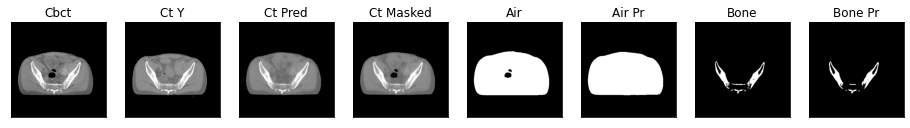

ssim score = 0.8991105556488037
psnr score = 26.13987159729004
snr score = 16.075517654418945
mae error = 0.016185583546757698
air dice score = 0.9844919844375107
bone dice score = 0.9227410551858976


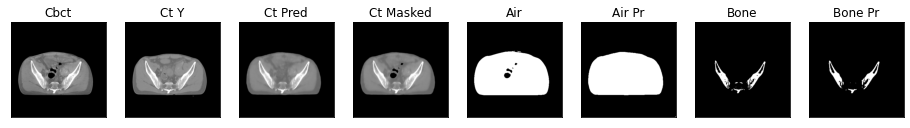

ssim score = 0.8944144248962402
psnr score = 25.47457504272461
snr score = 15.359539985656738
mae error = 0.01694432459771633
air dice score = 0.9841004552152001
bone dice score = 0.9226435027594477


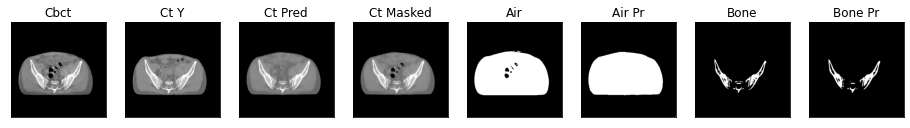

ssim score = 0.893777072429657
psnr score = 24.898075103759766
snr score = 14.770729064941406
mae error = 0.017892146483063698
air dice score = 0.9861078773768102
bone dice score = 0.9284170069669898


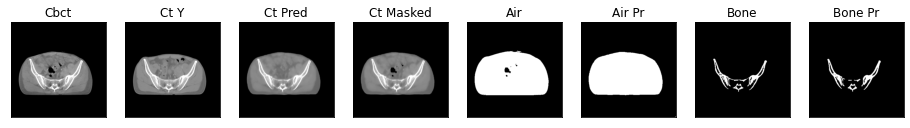

ssim score = 0.8901154398918152
psnr score = 24.50521469116211
snr score = 14.313024520874023
mae error = 0.01856977306306362
air dice score = 0.9869164736035245
bone dice score = 0.9113182423447228


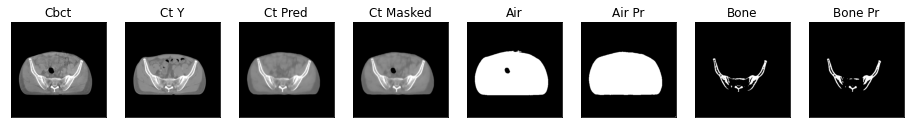

ssim score = 0.8886200189590454
psnr score = 24.196483612060547
snr score = 13.944863319396973
mae error = 0.018469462171196938
air dice score = 0.9885195010442078
bone dice score = 0.926986584108269


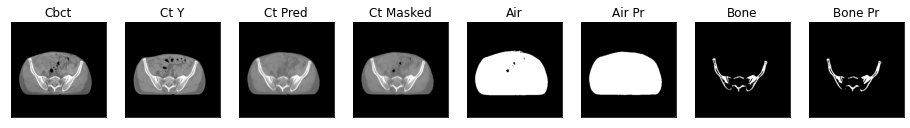

ssim score = 0.8897941708564758
psnr score = 24.053882598876953
snr score = 13.76883602142334
mae error = 0.018596354871988297
air dice score = 0.9890878343636218
bone dice score = 0.9326113116734943


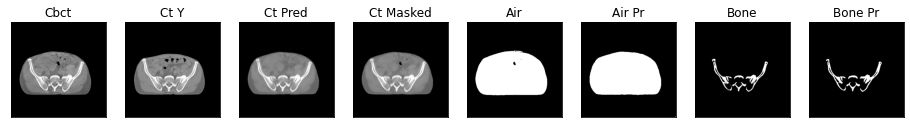

ssim score = 0.8893886804580688
psnr score = 23.846031188964844
snr score = 13.512418746948242
mae error = 0.019151564687490463
air dice score = 0.990187703460866
bone dice score = 0.9264569842746708


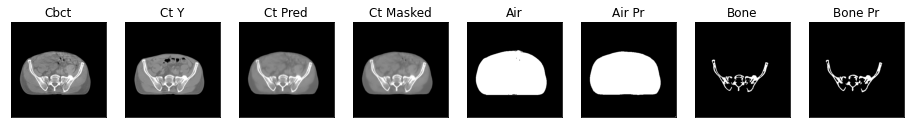

3it [00:07,  2.75s/it]

ssim score = 0.8875498175621033
psnr score = 23.6684627532959
snr score = 13.237849235534668
mae error = 0.01965838298201561
air dice score = 0.9896491495422537
bone dice score = 0.9348090758169916


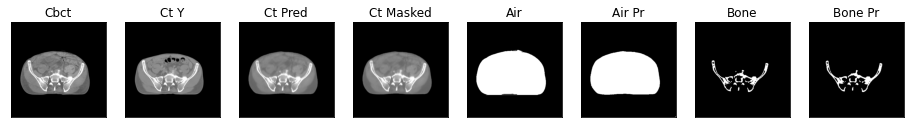

ssim score = 0.893578052520752
psnr score = 24.057327270507812
snr score = 13.543977737426758
mae error = 0.01851576566696167
air dice score = 0.9913895025974905
bone dice score = 0.913131313132288


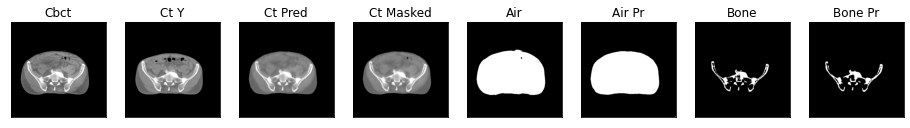

ssim score = 0.8905584216117859
psnr score = 23.959835052490234
snr score = 13.355302810668945
mae error = 0.019025100395083427
air dice score = 0.9914750584567524
bone dice score = 0.9186212972148594


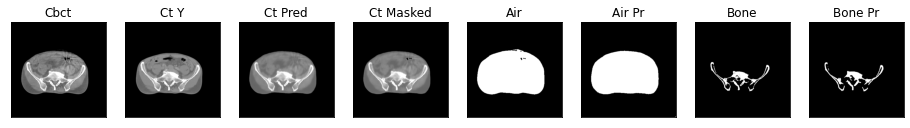

ssim score = 0.8910853266716003
psnr score = 23.835250854492188
snr score = 13.189610481262207
mae error = 0.01942327804863453
air dice score = 0.9909291735057931
bone dice score = 0.9236823029934381


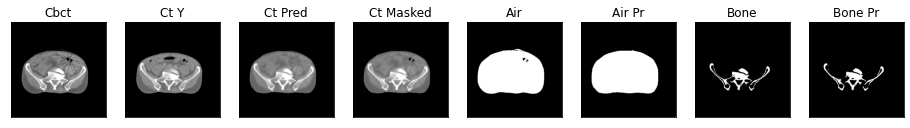

ssim score = 0.872046709060669
psnr score = 23.75371742248535
snr score = 15.125874519348145
mae error = 0.02061491087079048
air dice score = 0.9904869187396
bone dice score = 0.9732587064684932


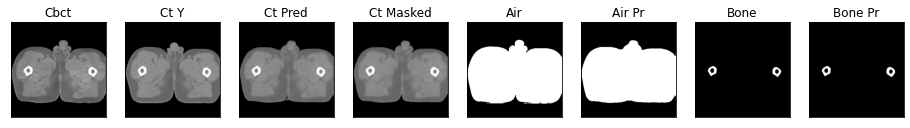

ssim score = 0.8763629794120789
psnr score = 24.460880279541016
snr score = 15.872295379638672
mae error = 0.01916678063571453
air dice score = 0.9903437099061441
bone dice score = 0.9760793465584574


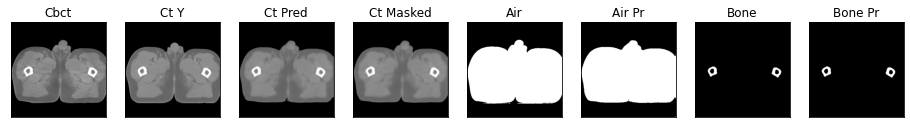

ssim score = 0.8862332701683044
psnr score = 25.142623901367188
snr score = 16.641489028930664
mae error = 0.01813223399221897
air dice score = 0.9911272532267358
bone dice score = 0.9639344262303529


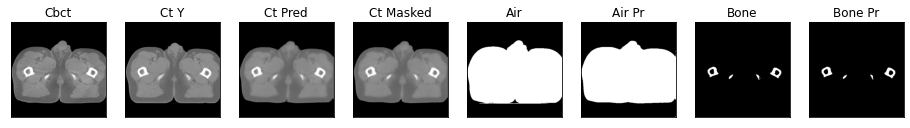

ssim score = 0.8908164501190186
psnr score = 25.959545135498047
snr score = 17.6209659576416
mae error = 0.01787765882909298
air dice score = 0.9921793408301605
bone dice score = 0.9690293742022824


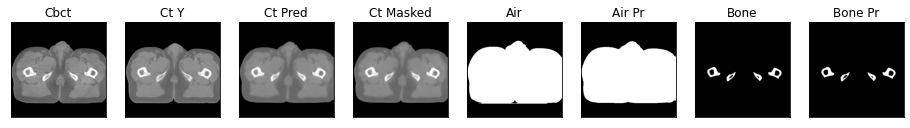

4it [00:10,  2.69s/it]

ssim score = 0.891451895236969
psnr score = 26.185701370239258
snr score = 17.975265502929688
mae error = 0.01774149388074875
air dice score = 0.9922102742128674
bone dice score = 0.9600109559030401


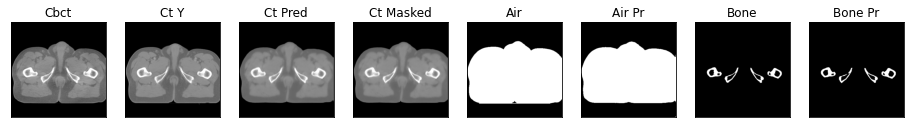

ssim score = 0.8914700746536255
psnr score = 26.582582473754883
snr score = 18.475383758544922
mae error = 0.0171804279088974
air dice score = 0.9913767110896753
bone dice score = 0.9545725527607657


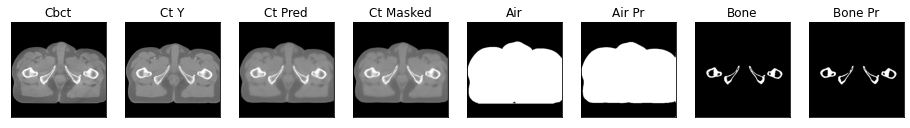

ssim score = 0.892314076423645
psnr score = 26.855676651000977
snr score = 18.81557846069336
mae error = 0.01736697368323803
air dice score = 0.9912210598422126
bone dice score = 0.9468503937013687


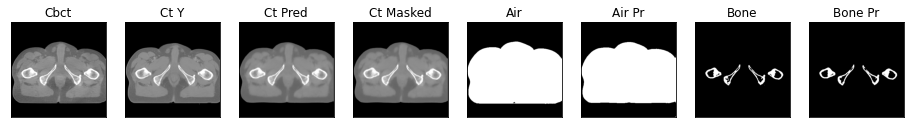

ssim score = 0.8925870060920715
psnr score = 27.03346061706543
snr score = 18.983474731445312
mae error = 0.0168968103826046
air dice score = 0.9910946507976514
bone dice score = 0.9591731266154091


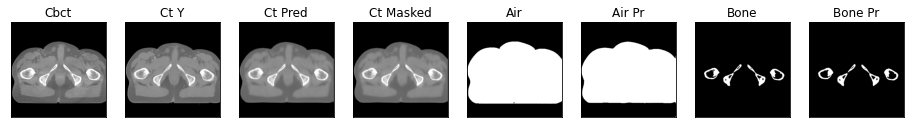

ssim score = 0.8944709300994873
psnr score = 26.98284912109375
snr score = 18.91919708251953
mae error = 0.017054447904229164
air dice score = 0.9906119568987224
bone dice score = 0.9611640536944239


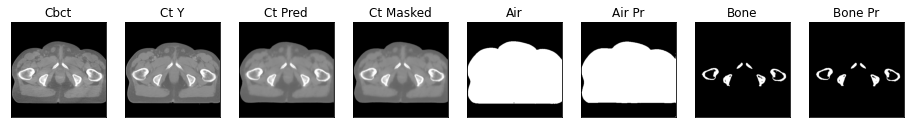

ssim score = 0.9017620086669922
psnr score = 27.68621253967285
snr score = 19.63456153869629
mae error = 0.016477150842547417
air dice score = 0.9919145508249593
bone dice score = 0.9569357281978258


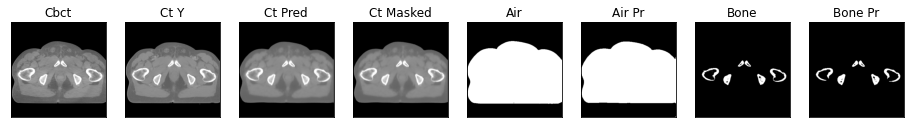

ssim score = 0.9031179547309875
psnr score = 27.596515655517578
snr score = 19.583948135375977
mae error = 0.016654860228300095
air dice score = 0.9915056072536438
bone dice score = 0.9546571364758247


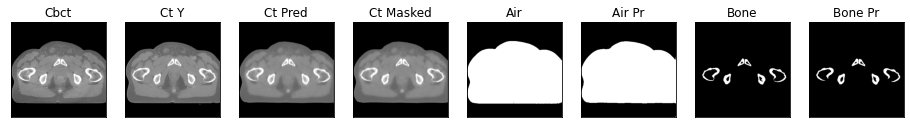

ssim score = 0.9042164087295532
psnr score = 27.827850341796875
snr score = 19.956571578979492
mae error = 0.016835076734423637
air dice score = 0.9924568130184123
bone dice score = 0.9504894041627816


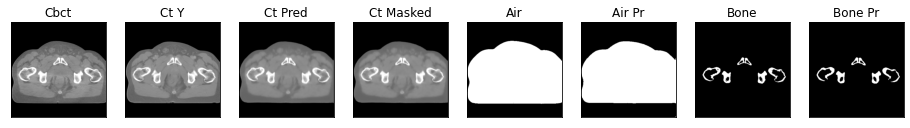

5it [00:12,  2.59s/it]

ssim score = 0.8986740708351135
psnr score = 27.414413452148438
snr score = 19.6378231048584
mae error = 0.017401423305273056
air dice score = 0.9917202211926518
bone dice score = 0.9534129557861788


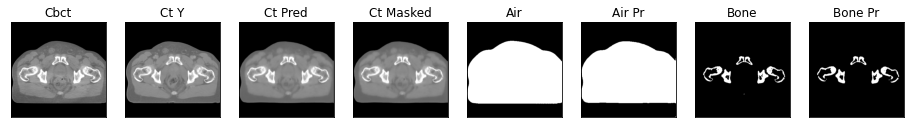

ssim score = 0.8891700506210327
psnr score = 26.786792755126953
snr score = 18.976154327392578
mae error = 0.019127925857901573
air dice score = 0.9918022963158323
bone dice score = 0.9267833320260003


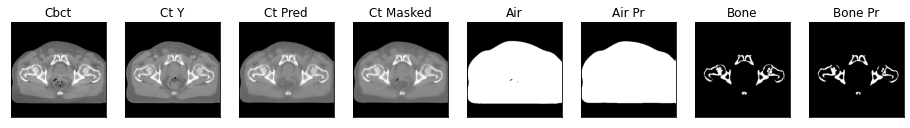

ssim score = 0.8873319029808044
psnr score = 26.790218353271484
snr score = 19.05176544189453
mae error = 0.019279325380921364
air dice score = 0.9903652305785132
bone dice score = 0.903053539641907


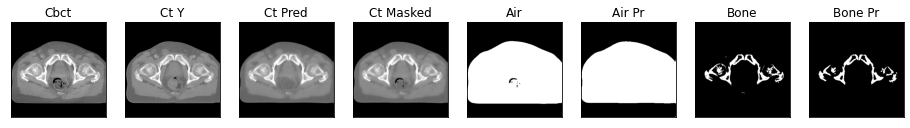

ssim score = 0.8828189373016357
psnr score = 26.35626983642578
snr score = 18.48172378540039
mae error = 0.019637806341052055
air dice score = 0.9894552482183903
bone dice score = 0.8879202988802


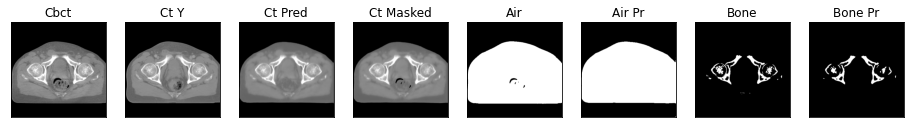

ssim score = 0.8894156813621521
psnr score = 26.57712745666504
snr score = 18.524019241333008
mae error = 0.018518421798944473
air dice score = 0.9913759689922533
bone dice score = 0.8802093819218824


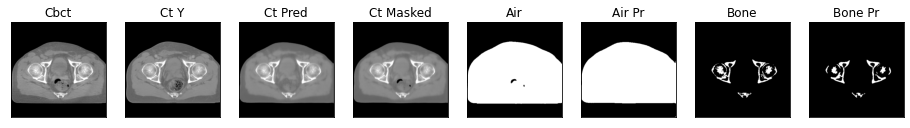

ssim score = 0.8870750665664673
psnr score = 25.916683197021484
snr score = 17.77298927307129
mae error = 0.019447002559900284
air dice score = 0.9924797414683381
bone dice score = 0.8706818181832876


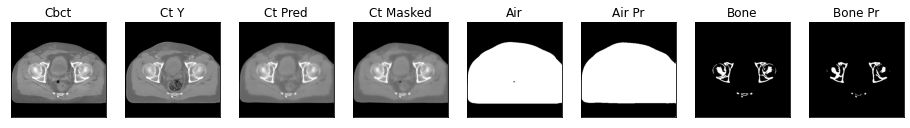

ssim score = 0.8893697261810303
psnr score = 25.76936912536621
snr score = 17.641366958618164
mae error = 0.019485799595713615
air dice score = 0.9928784577925094
bone dice score = 0.8885627424269991


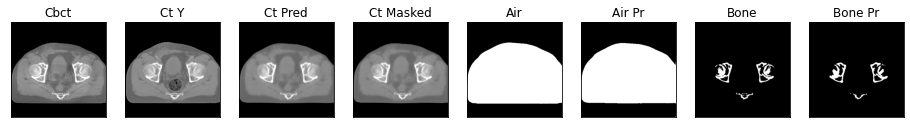

ssim score = 0.8779844045639038
psnr score = 25.639202117919922
snr score = 17.52123260498047
mae error = 0.020343784242868423
air dice score = 0.9926074073165241
bone dice score = 0.9015979814979759


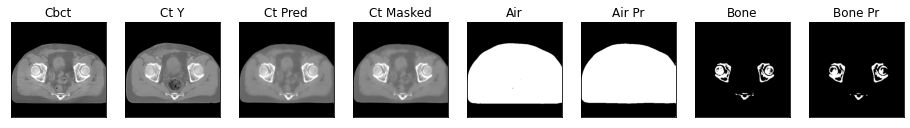

6it [00:15,  2.58s/it]

ssim score = 0.8839894533157349
psnr score = 26.00334930419922
snr score = 17.94696807861328
mae error = 0.019467182457447052
air dice score = 0.9920358724507757
bone dice score = 0.9386907449215468


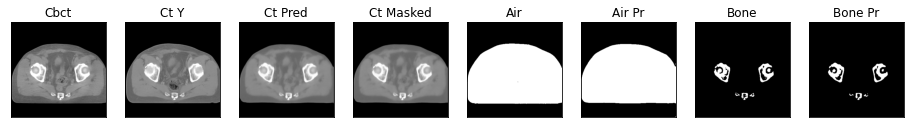

ssim score = 0.8878254294395447
psnr score = 26.936540603637695
snr score = 18.950246810913086
mae error = 0.01813380792737007
air dice score = 0.9922441399139931
bone dice score = 0.9614917606247919


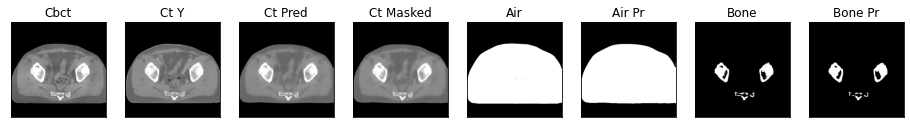

ssim score = 0.8893541097640991
psnr score = 26.405433654785156
snr score = 18.300031661987305
mae error = 0.018894214183092117
air dice score = 0.9916974796140768
bone dice score = 0.9459671104155641


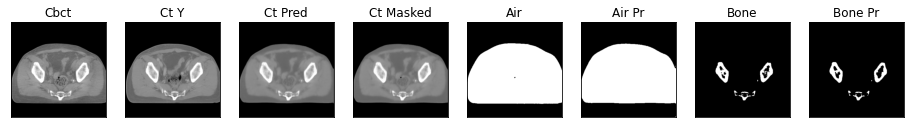

ssim score = 0.8836345076560974
psnr score = 25.781726837158203
snr score = 17.757951736450195
mae error = 0.02050711400806904
air dice score = 0.9903276746940447
bone dice score = 0.9578080349642141


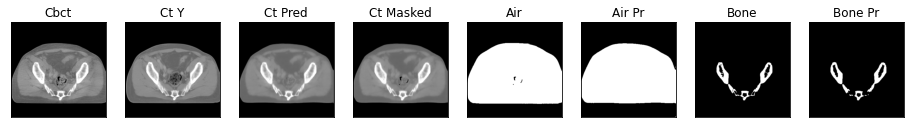

ssim score = 0.8812889456748962
psnr score = 25.87254524230957
snr score = 17.928918838500977
mae error = 0.020520919933915138
air dice score = 0.9888584699621712
bone dice score = 0.9563324908736568


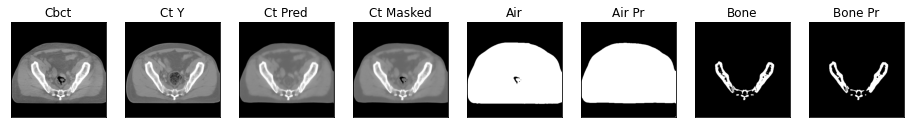

ssim score = 0.8696452379226685
psnr score = 25.490272521972656
snr score = 17.568201065063477
mae error = 0.022278213873505592
air dice score = 0.9885091301521967
bone dice score = 0.9460366279886339


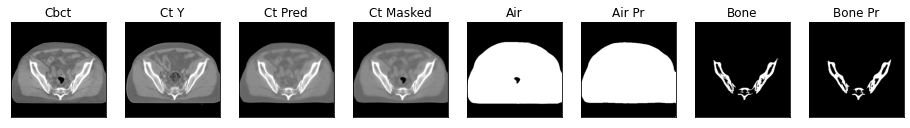

ssim score = 0.8719092011451721
psnr score = 25.698223114013672
snr score = 17.7886905670166
mae error = 0.022028081119060516
air dice score = 0.9907326732673324
bone dice score = 0.9535445375766902


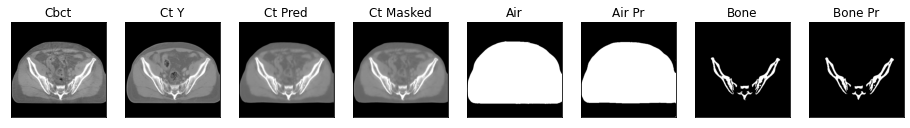

ssim score = 0.825587809085846
psnr score = 21.25015640258789
snr score = 11.130366325378418
mae error = 0.030371682718396187
air dice score = 0.9935571744760222
bone dice score = 0.9605263157905557


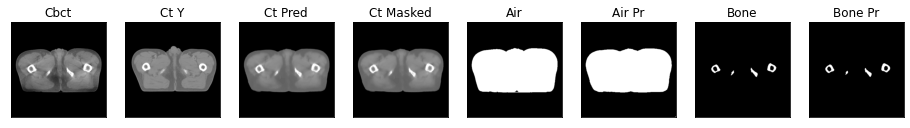

7it [00:17,  2.57s/it]

ssim score = 0.8141506314277649
psnr score = 20.905027389526367
snr score = 10.99821662902832
mae error = 0.032773274928331375
air dice score = 0.9937011662197254
bone dice score = 0.9325290437906048


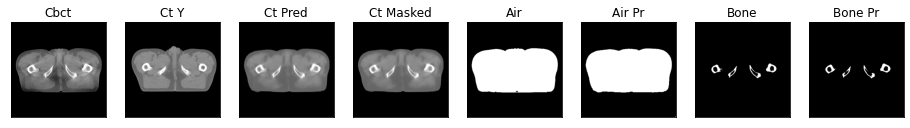

ssim score = 0.8081555962562561
psnr score = 20.89137840270996
snr score = 11.115705490112305
mae error = 0.03341400995850563
air dice score = 0.993908162000395
bone dice score = 0.8988030467921915


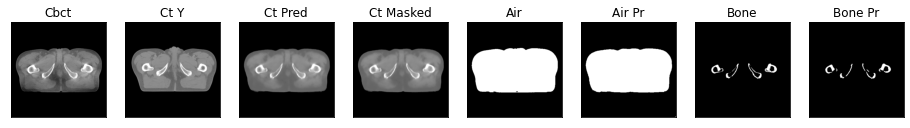

ssim score = 0.8111210465431213
psnr score = 21.208560943603516
snr score = 11.503291130065918
mae error = 0.032460808753967285
air dice score = 0.9934062059238422
bone dice score = 0.8934460887971787


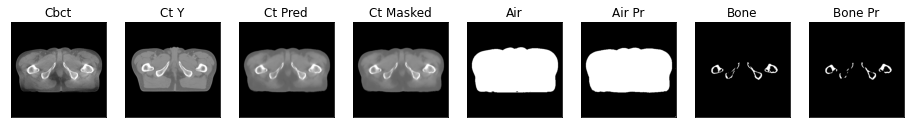

ssim score = 0.8109824657440186
psnr score = 21.258878707885742
snr score = 11.601175308227539
mae error = 0.03235369920730591
air dice score = 0.9906120651695371
bone dice score = 0.8899775464402944


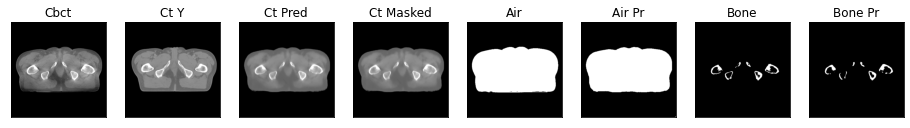

ssim score = 0.8128132820129395
psnr score = 21.40909194946289
snr score = 11.757003784179688
mae error = 0.03193400055170059
air dice score = 0.9912561986367456
bone dice score = 0.9016553067205131


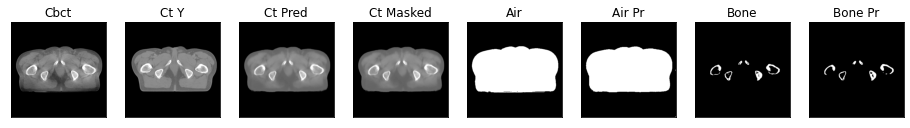

ssim score = 0.8126858472824097
psnr score = 21.422643661499023
snr score = 11.764053344726562
mae error = 0.03174291551113129
air dice score = 0.9906443997551887
bone dice score = 0.930438124520937


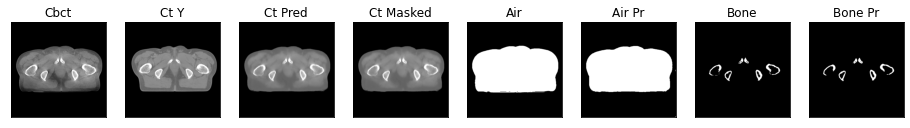

ssim score = 0.8123475313186646
psnr score = 21.260303497314453
snr score = 11.615821838378906
mae error = 0.032140567898750305
air dice score = 0.9899120244831854
bone dice score = 0.9381845182859071


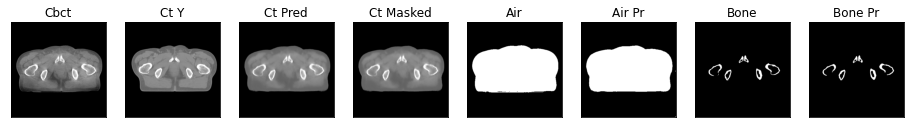

ssim score = 0.8118706345558167
psnr score = 21.207195281982422
snr score = 11.620721817016602
mae error = 0.03273943066596985
air dice score = 0.9908451869724738
bone dice score = 0.9129199398309724


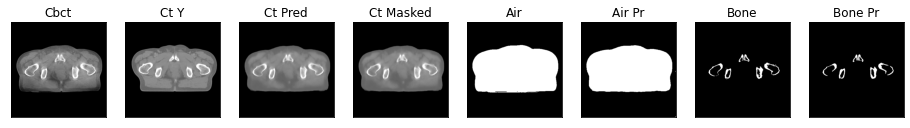

8it [00:20,  2.50s/it]

ssim score = 0.8068856596946716
psnr score = 21.057292938232422
snr score = 11.569380760192871
mae error = 0.03430313244462013
air dice score = 0.9908435240715586
bone dice score = 0.8659759358311168


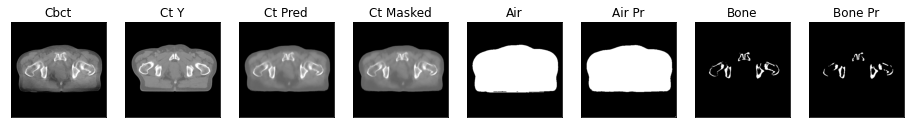

ssim score = 0.7954728007316589
psnr score = 20.832530975341797
snr score = 11.380444526672363
mae error = 0.03591268137097359
air dice score = 0.9914926795460526
bone dice score = 0.8666878778258561


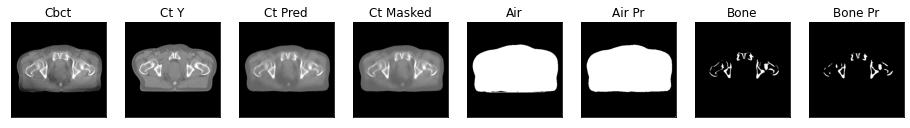

ssim score = 0.7848809957504272
psnr score = 20.754196166992188
snr score = 11.334817886352539
mae error = 0.036222413182258606
air dice score = 0.9920720689565805
bone dice score = 0.843950406158701


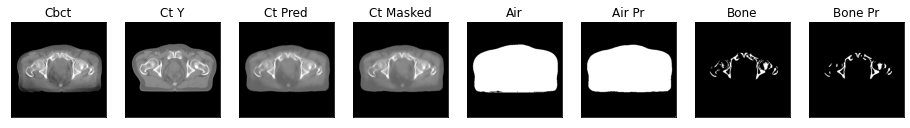

ssim score = 0.786471426486969
psnr score = 20.76603126525879
snr score = 11.463469505310059
mae error = 0.03661641106009483
air dice score = 0.992424242424249
bone dice score = 0.8362268518542213


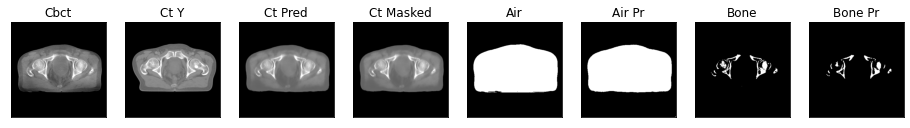

ssim score = 0.7880679368972778
psnr score = 20.6973876953125
snr score = 11.378841400146484
mae error = 0.03703474625945091
air dice score = 0.9937214463991211
bone dice score = 0.8364448699563356


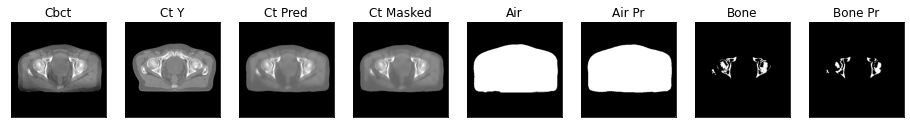

ssim score = 0.802070677280426
psnr score = 21.15709114074707
snr score = 11.639379501342773
mae error = 0.03404679894447327
air dice score = 0.9938640776699083
bone dice score = 0.868315508023591


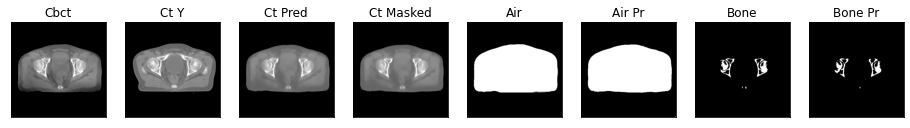

ssim score = 0.8181618452072144
psnr score = 21.916858673095703
snr score = 12.228754043579102
mae error = 0.03077027201652527
air dice score = 0.9940075422313347
bone dice score = 0.905026256565566


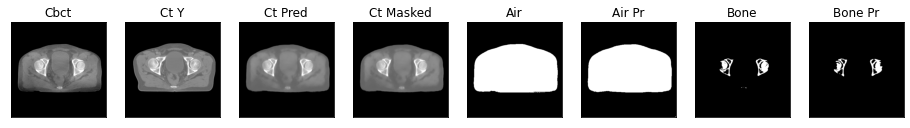

ssim score = 0.8245375156402588
psnr score = 22.2447509765625
snr score = 12.570815086364746
mae error = 0.029441723600029945
air dice score = 0.9930964606481143
bone dice score = 0.9356502850945473


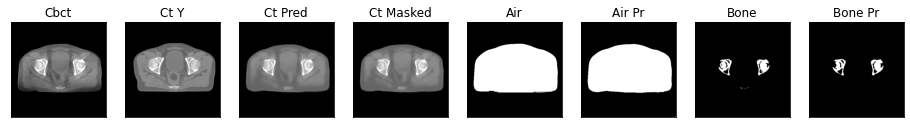

9it [00:22,  2.52s/it]

ssim score = 0.8288013339042664
psnr score = 22.513137817382812
snr score = 12.921029090881348
mae error = 0.028749261051416397
air dice score = 0.9935383377694911
bone dice score = 0.9523680649532833


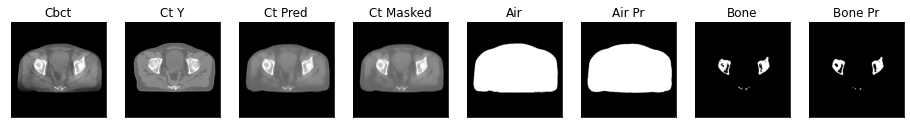

ssim score = 0.8274615406990051
psnr score = 22.414854049682617
snr score = 12.9149169921875
mae error = 0.029245320707559586
air dice score = 0.9926327305049463
bone dice score = 0.938404681245174


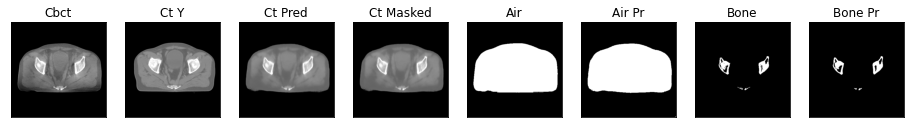

ssim score = 0.8274393677711487
psnr score = 22.807674407958984
snr score = 13.244312286376953
mae error = 0.027627626433968544
air dice score = 0.9931232872048944
bone dice score = 0.9534961525601623


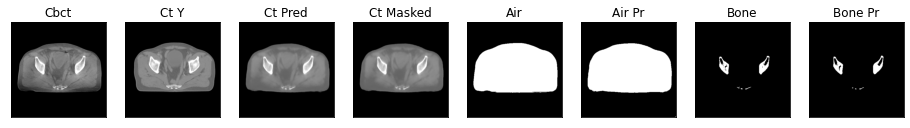

ssim score = 0.8312514424324036
psnr score = 23.103132247924805
snr score = 13.503376007080078
mae error = 0.026510918512940407
air dice score = 0.9917136228041171
bone dice score = 0.9554788297300476


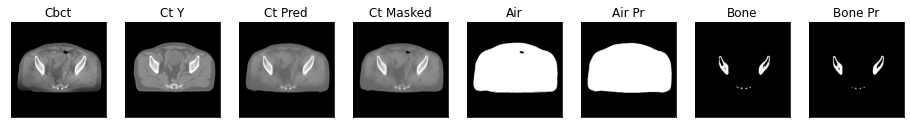

ssim score = 0.8278192281723022
psnr score = 22.956912994384766
snr score = 13.394904136657715
mae error = 0.027655472978949547
air dice score = 0.9914749742375668
bone dice score = 0.9234711308520077


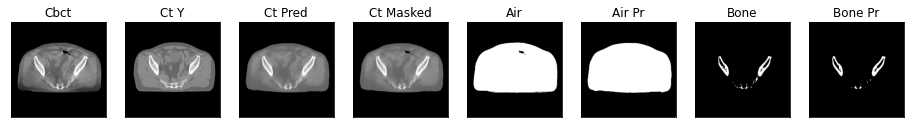

ssim score = 0.8221137523651123
psnr score = 22.728057861328125
snr score = 13.296552658081055
mae error = 0.028743194416165352
air dice score = 0.9928321216408622
bone dice score = 0.9207003089610019


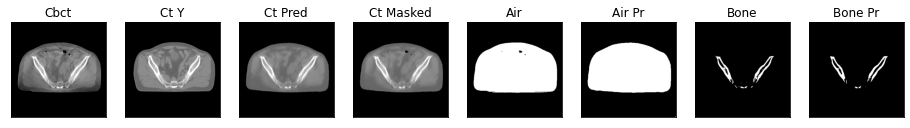

ssim score = 0.8266109824180603
psnr score = 22.78534698486328
snr score = 13.371591567993164
mae error = 0.02850949764251709
air dice score = 0.9924846783305437
bone dice score = 0.8995368152068434


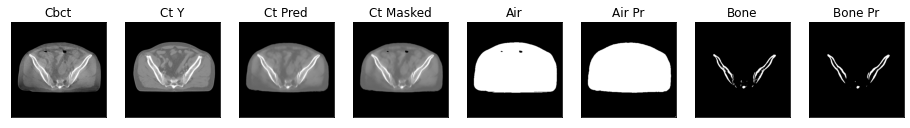

ssim score = 0.8316002488136292
psnr score = 23.103919982910156
snr score = 13.67889404296875
mae error = 0.02771095186471939
air dice score = 0.9926850258175622
bone dice score = 0.9199517989340686


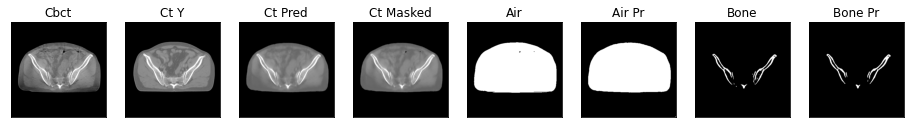

10it [00:25,  2.53s/it]

ssim score = 0.8347480893135071
psnr score = 23.21794319152832
snr score = 13.792177200317383
mae error = 0.02712946943938732
air dice score = 0.9926261464915909
bone dice score = 0.8919516760270214


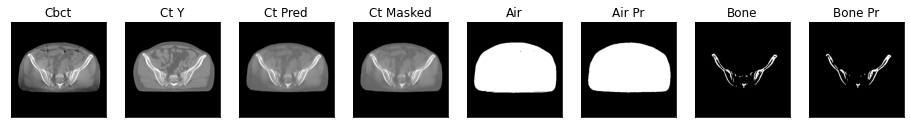

ssim score = 0.8801310658454895
psnr score = 24.469684600830078
snr score = 14.903820037841797
mae error = 0.018476851284503937
air dice score = 0.9910933243867246
bone dice score = 0.9510436432656151


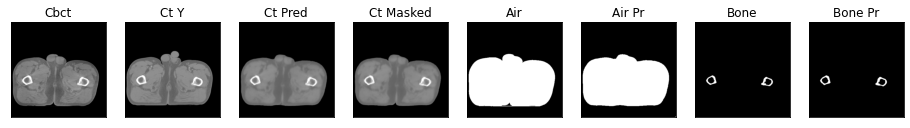

ssim score = 0.8818033933639526
psnr score = 24.780376434326172
snr score = 15.278901100158691
mae error = 0.018090983852744102
air dice score = 0.9903695515598858
bone dice score = 0.9377211606533007


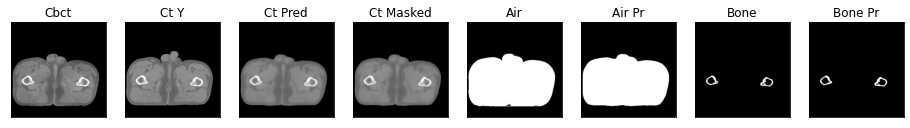

ssim score = 0.8921920657157898
psnr score = 26.748214721679688
snr score = 17.38595199584961
mae error = 0.01640499010682106
air dice score = 0.989512248812864
bone dice score = 0.9433875773563285


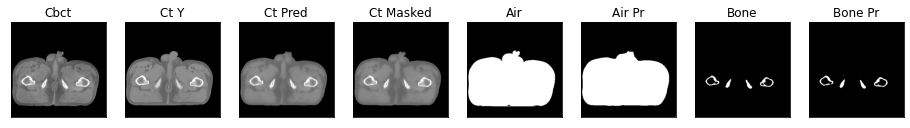

ssim score = 0.8942601084709167
psnr score = 26.890466690063477
snr score = 17.649696350097656
mae error = 0.016483206301927567
air dice score = 0.9911945947636842
bone dice score = 0.927913766002068


ssim score = 0.8892652988433838
psnr score = 26.59796142578125
snr score = 17.381366729736328
mae error = 0.01685812883079052
air dice score = 0.9915079111332988
bone dice score = 0.9022732599038604


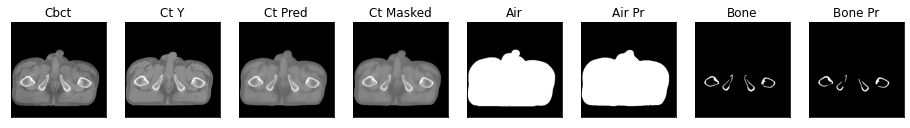

ssim score = 0.8904043436050415
psnr score = 26.51734161376953
snr score = 17.296348571777344
mae error = 0.01691277138888836
air dice score = 0.9915597016670239
bone dice score = 0.8725125738055431


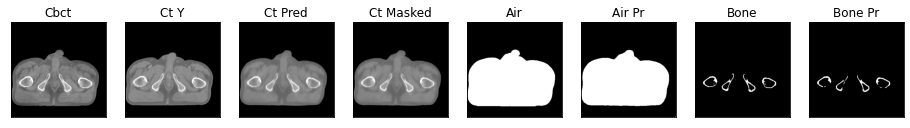

ssim score = 0.8887913227081299
psnr score = 25.85301971435547
snr score = 16.638280868530273
mae error = 0.017726944759488106
air dice score = 0.9913485370454153
bone dice score = 0.8930271053198215


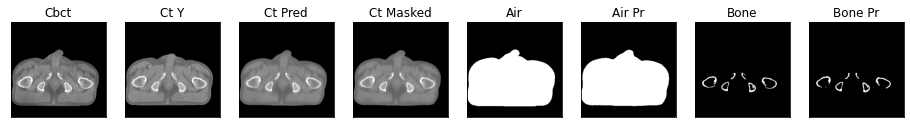

11it [00:27,  2.47s/it]

ssim score = 0.8874570727348328
psnr score = 25.673856735229492
snr score = 16.437562942504883
mae error = 0.01761273294687271
air dice score = 0.9922995385958409
bone dice score = 0.9136603161752399


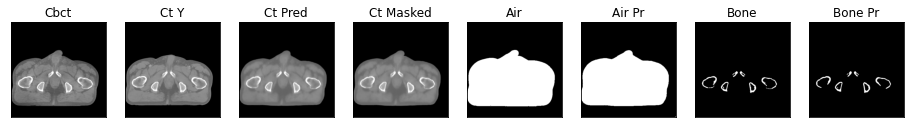

ssim score = 0.8902425169944763
psnr score = 25.750015258789062
snr score = 16.530630111694336
mae error = 0.017453094944357872
air dice score = 0.9917604752970671
bone dice score = 0.9252441773116972


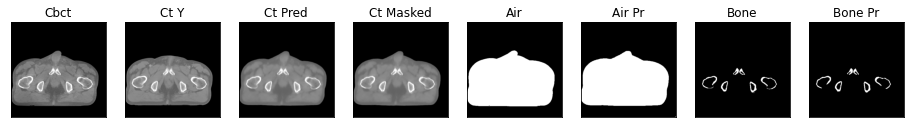

ssim score = 0.8893525004386902
psnr score = 25.97419548034668
snr score = 16.82340431213379
mae error = 0.017360107973217964
air dice score = 0.9917834474957646
bone dice score = 0.9177820267700716


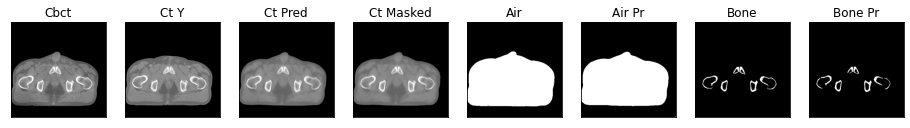

ssim score = 0.8905066847801208
psnr score = 26.522953033447266
snr score = 17.453521728515625
mae error = 0.016973039135336876
air dice score = 0.9938432953328763
bone dice score = 0.9015944596569239


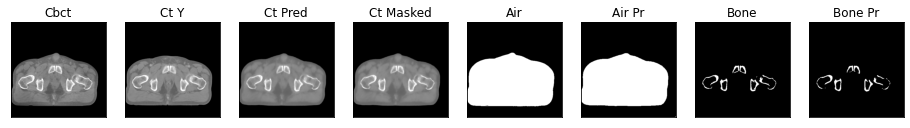

ssim score = 0.8951834440231323
psnr score = 27.21316146850586
snr score = 18.19443130493164
mae error = 0.01641896553337574
air dice score = 0.9930484709008572
bone dice score = 0.8618661580056928


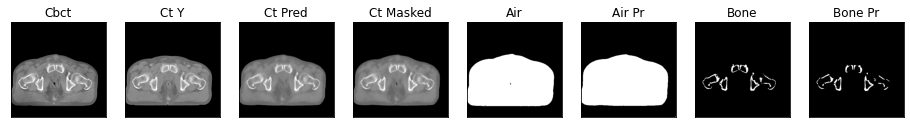

ssim score = 0.8966493606567383
psnr score = 27.438213348388672
snr score = 18.535751342773438
mae error = 0.01636785827577114
air dice score = 0.9928915968519986
bone dice score = 0.8366322008886761


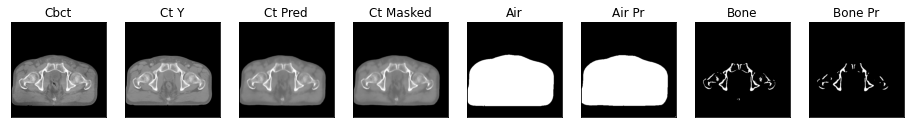

ssim score = 0.8974462151527405
psnr score = 27.775442123413086
snr score = 18.834747314453125
mae error = 0.015927597880363464
air dice score = 0.9913741607130125
bone dice score = 0.8218381521592337


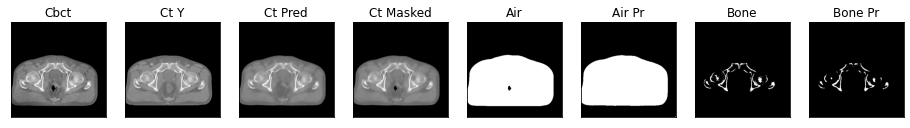

ssim score = 0.8880724906921387
psnr score = 27.361888885498047
snr score = 18.32552146911621
mae error = 0.01641392521560192
air dice score = 0.987730553327997
bone dice score = 0.8023880597044419


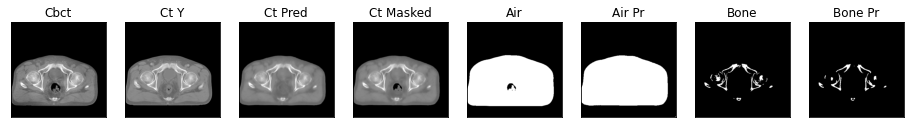

12it [00:30,  2.50s/it]

ssim score = 0.8893606662750244
psnr score = 27.231040954589844
snr score = 18.034915924072266
mae error = 0.01635659858584404
air dice score = 0.9842661435502618
bone dice score = 0.8252409529037054


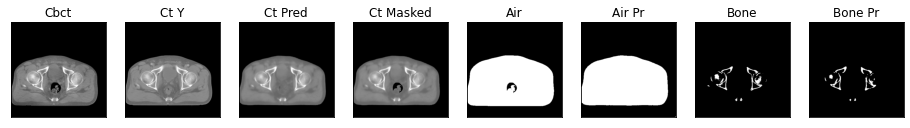

ssim score = 0.8882450461387634
psnr score = 26.248149871826172
snr score = 16.935598373413086
mae error = 0.016982078552246094
air dice score = 0.9852173417278319
bone dice score = 0.8270422535243748


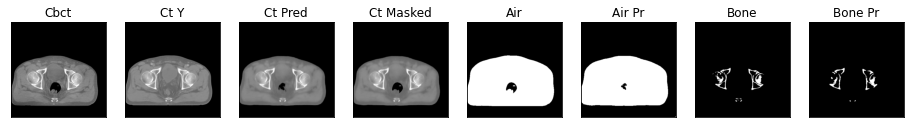

ssim score = 0.885248601436615
psnr score = 25.484819412231445
snr score = 16.127174377441406
mae error = 0.017836637794971466
air dice score = 0.98704371616127
bone dice score = 0.8616395710850633


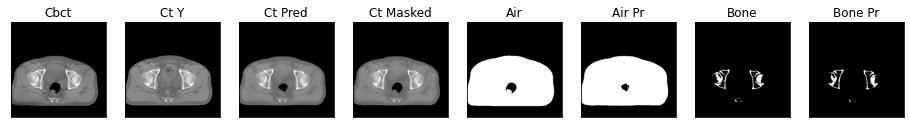

ssim score = 0.8763293623924255
psnr score = 24.867107391357422
snr score = 15.516136169433594
mae error = 0.019474510103464127
air dice score = 0.9857399995068705
bone dice score = 0.9085477178438416


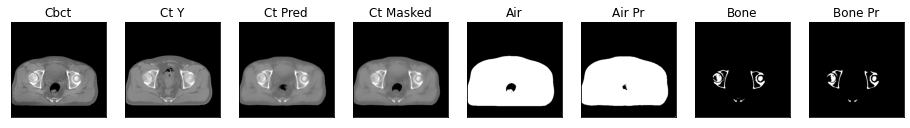

ssim score = 0.8769633173942566
psnr score = 24.028947830200195
snr score = 14.708078384399414
mae error = 0.02085396647453308
air dice score = 0.9894173337629273
bone dice score = 0.9380102812225883


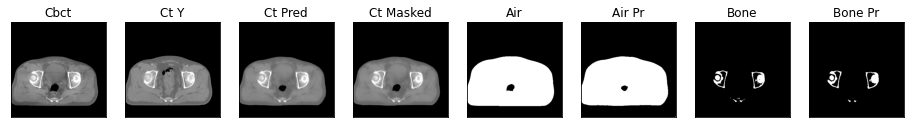

ssim score = 0.881511390209198
psnr score = 24.664213180541992
snr score = 15.300758361816406
mae error = 0.01934068463742733
air dice score = 0.9899241424802194
bone dice score = 0.9254190899773278


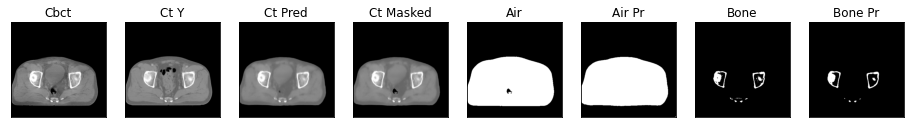

ssim score = 0.8832256197929382
psnr score = 24.61446762084961
snr score = 15.160809516906738
mae error = 0.018882282078266144
air dice score = 0.9913693757928058
bone dice score = 0.9106933019993989


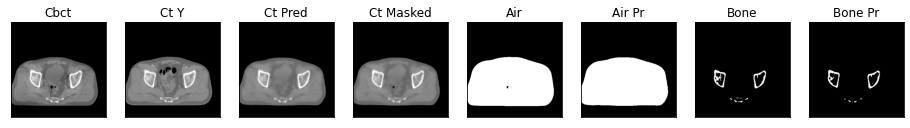

ssim score = 0.8823379874229431
psnr score = 24.662057876586914
snr score = 15.14267349243164
mae error = 0.018758952617645264
air dice score = 0.9896237782835808
bone dice score = 0.9339207048471382


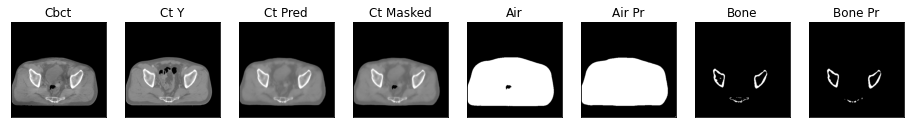

13it [00:32,  2.51s/it]

ssim score = 0.8825323581695557
psnr score = 24.954320907592773
snr score = 15.434635162353516
mae error = 0.018517129123210907
air dice score = 0.9888197500885408
bone dice score = 0.9290528556238196


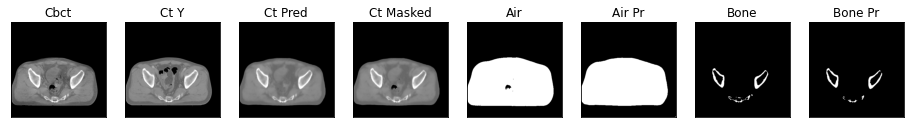

ssim score = 0.8757480978965759
psnr score = 24.95136260986328
snr score = 15.507842063903809
mae error = 0.01942058838903904
air dice score = 0.9881040449648495
bone dice score = 0.9146627565994917


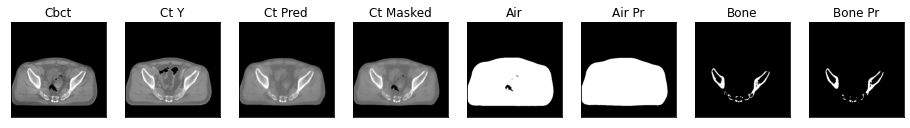

ssim score = 0.8802818059921265
psnr score = 25.048263549804688
snr score = 15.640325546264648
mae error = 0.019019076600670815
air dice score = 0.9882439634637565
bone dice score = 0.9190136100266943


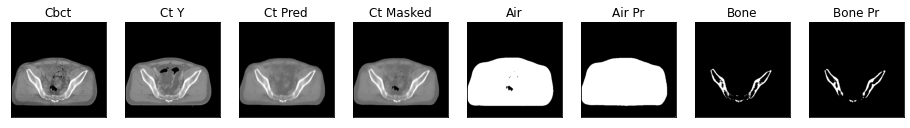

ssim score = 0.8818607330322266
psnr score = 25.181941986083984
snr score = 15.712305068969727
mae error = 0.01851428672671318
air dice score = 0.9889609100560249
bone dice score = 0.9005998286218138


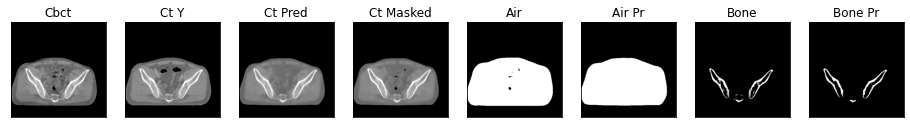

ssim score = 0.8795053958892822
psnr score = 24.884702682495117
snr score = 15.35380744934082
mae error = 0.019119510427117348
air dice score = 0.9889622033809877
bone dice score = 0.8911854103360002


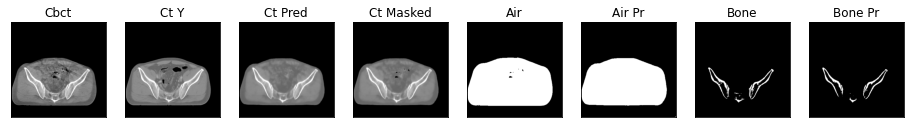

ssim score = 0.8265916705131531
psnr score = 22.938081741333008
snr score = 14.63538932800293
mae error = 0.027526428923010826
air dice score = 0.9932382380306186
bone dice score = 0.9639751552806219


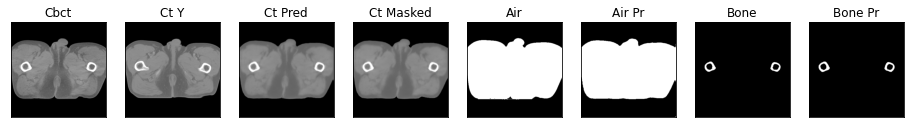

ssim score = 0.8156023025512695
psnr score = 22.410240173339844
snr score = 14.211840629577637
mae error = 0.029424479231238365
air dice score = 0.9942912353672436
bone dice score = 0.9617425300206159


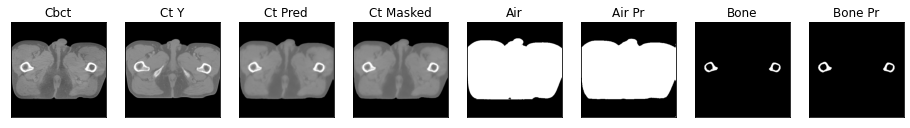

ssim score = 0.809269368648529
psnr score = 22.13445281982422
snr score = 14.064005851745605
mae error = 0.031552039086818695
air dice score = 0.9944331775563622
bone dice score = 0.9341235468444467


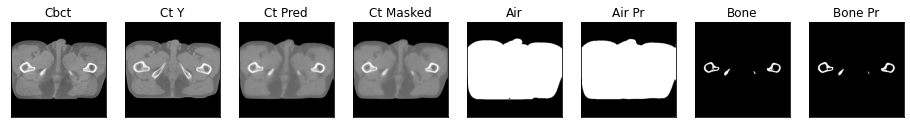

14it [00:35,  2.46s/it]

ssim score = 0.7979606986045837
psnr score = 21.691970825195312
snr score = 13.653814315795898
mae error = 0.032341670244932175
air dice score = 0.9940467462388961
bone dice score = 0.9487179487188138


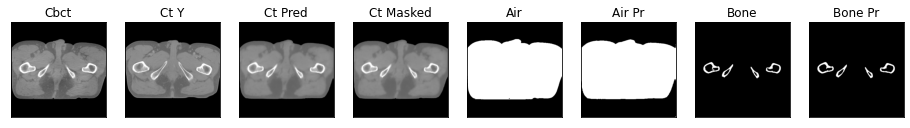

ssim score = 0.7880502343177795
psnr score = 21.45203399658203
snr score = 13.444114685058594
mae error = 0.03375188261270523
air dice score = 0.9940329940329975
bone dice score = 0.9143330571679481


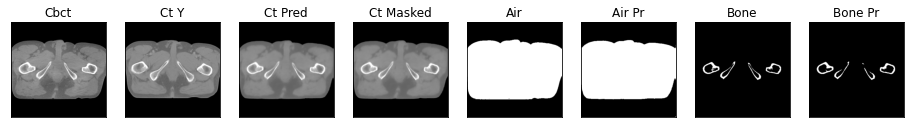

ssim score = 0.7816143035888672
psnr score = 21.341556549072266
snr score = 13.368057250976562
mae error = 0.03477218374609947
air dice score = 0.9942793163170727
bone dice score = 0.9278967254419411


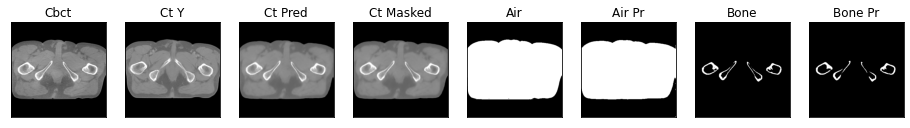

ssim score = 0.7770929932594299
psnr score = 21.1199951171875
snr score = 13.166804313659668
mae error = 0.035698387771844864
air dice score = 0.9937883867818766
bone dice score = 0.9228201919076231


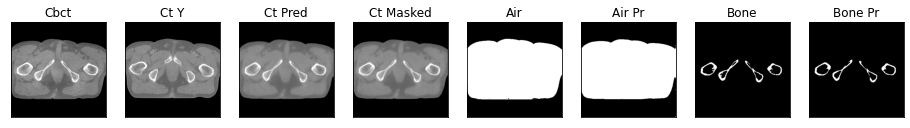

ssim score = 0.7753943204879761
psnr score = 21.13140869140625
snr score = 13.21728801727295
mae error = 0.035634711384773254
air dice score = 0.9937648989913673
bone dice score = 0.916631987794193


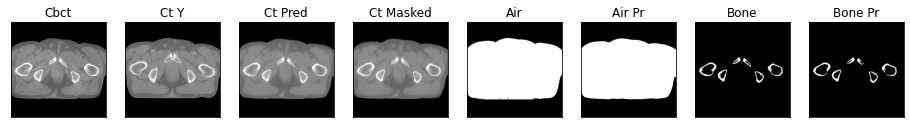

ssim score = 0.7762590646743774
psnr score = 21.281665802001953
snr score = 13.416227340698242
mae error = 0.03521771728992462
air dice score = 0.993457911403421
bone dice score = 0.9264666843651915


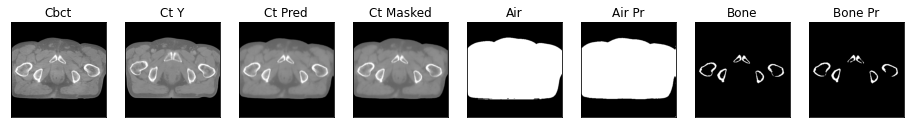

ssim score = 0.7686772346496582
psnr score = 21.08824920654297
snr score = 13.245421409606934
mae error = 0.03687913715839386
air dice score = 0.9937598859745217
bone dice score = 0.9203833865824871


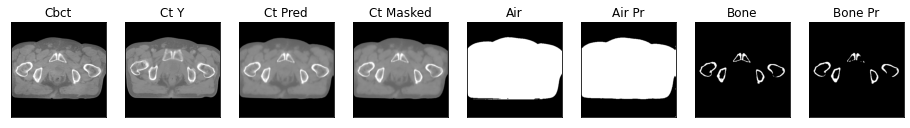

ssim score = 0.7536339163780212
psnr score = 20.958446502685547
snr score = 13.158398628234863
mae error = 0.03857600688934326
air dice score = 0.9939372222190148
bone dice score = 0.906518321442659


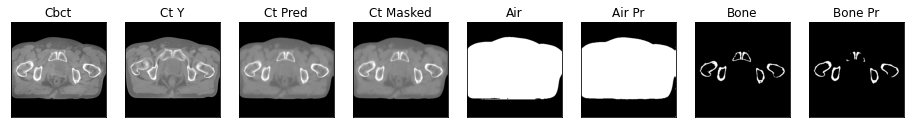

15it [00:37,  2.50s/it]

ssim score = 0.7578606009483337
psnr score = 21.08985137939453
snr score = 13.348140716552734
mae error = 0.03824254497885704
air dice score = 0.9938324264502479
bone dice score = 0.9031827286901493


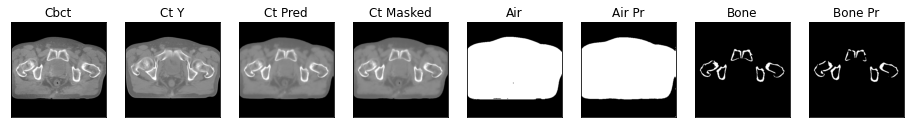

ssim score = 0.7537410855293274
psnr score = 20.86310577392578
snr score = 13.046025276184082
mae error = 0.04024847224354744
air dice score = 0.9948315356900332
bone dice score = 0.8861487875063075


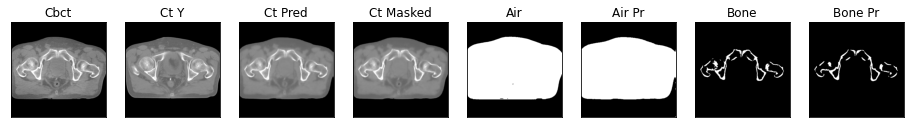

ssim score = 0.7578176856040955
psnr score = 20.72126007080078
snr score = 12.796957015991211
mae error = 0.04151149466633797
air dice score = 0.995067767834022
bone dice score = 0.8610121168937888


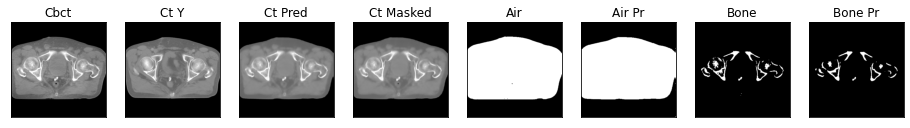

ssim score = 0.7720097899436951
psnr score = 20.920734405517578
snr score = 12.873344421386719
mae error = 0.040255915373563766
air dice score = 0.9951799874460872
bone dice score = 0.8185031185050051


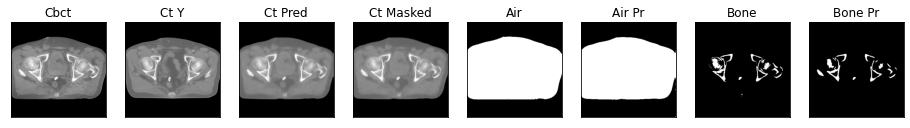

ssim score = 0.7726877927780151
psnr score = 21.13762664794922
snr score = 12.977807998657227
mae error = 0.03910061717033386
air dice score = 0.9953763298102648
bone dice score = 0.8610009645283355


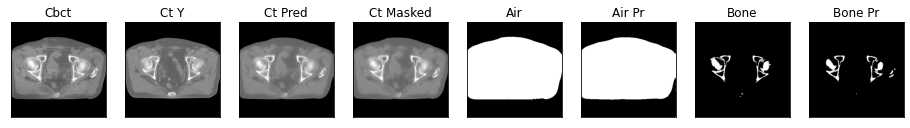

ssim score = 0.7726327776908875
psnr score = 21.511343002319336
snr score = 13.300875663757324
mae error = 0.03608705848455429
air dice score = 0.9953687086802004
bone dice score = 0.8806388948858122


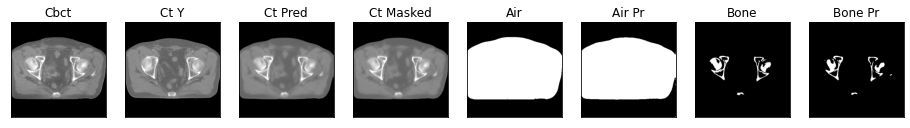

ssim score = 0.7710169553756714
psnr score = 21.325374603271484
snr score = 13.147062301635742
mae error = 0.03738876432180405
air dice score = 0.995686477134848
bone dice score = 0.890718394046569


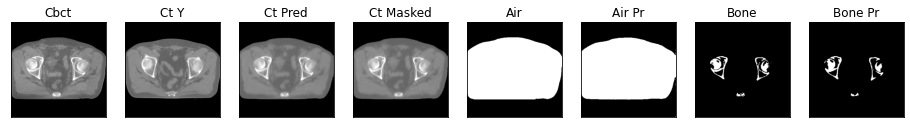

ssim score = 0.7699546217918396
psnr score = 21.110111236572266
snr score = 12.94527530670166
mae error = 0.03829795867204666
air dice score = 0.9952337112957574
bone dice score = 0.8989615149676364


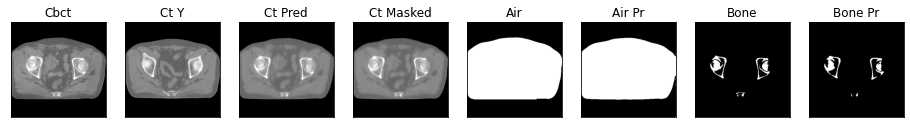

16it [00:40,  2.45s/it]

ssim score = 0.7685244083404541
psnr score = 20.68368911743164
snr score = 12.377362251281738
mae error = 0.04011266678571701
air dice score = 0.9953321658867448
bone dice score = 0.9251457812694852


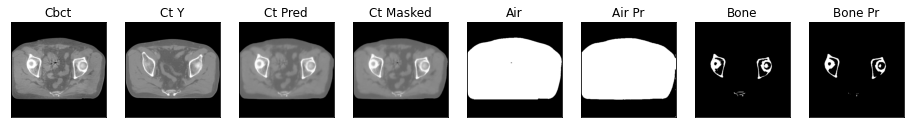

ssim score = 0.7788976430892944
psnr score = 20.876842498779297
snr score = 12.511207580566406
mae error = 0.038605768233537674
air dice score = 0.9950755746144723
bone dice score = 0.9183901621028733


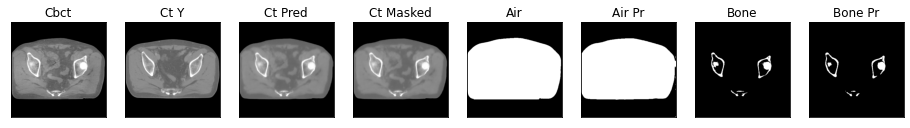

ssim score = 0.7791106700897217
psnr score = 21.260761260986328
snr score = 12.920778274536133
mae error = 0.03629908338189125
air dice score = 0.99542708209928
bone dice score = 0.9041309431039725


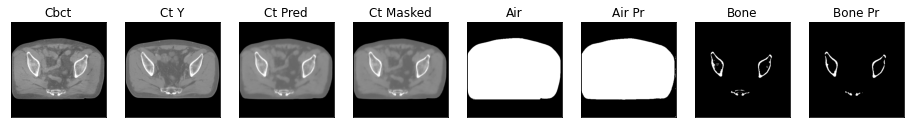

ssim score = 0.7748802304267883
psnr score = 21.229259490966797
snr score = 12.962087631225586
mae error = 0.03644481673836708
air dice score = 0.995542276950182
bone dice score = 0.9112917795860652


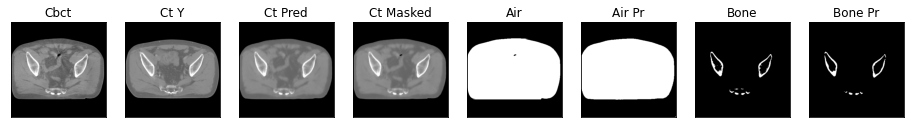

ssim score = 0.7691083550453186
psnr score = 21.025466918945312
snr score = 12.887523651123047
mae error = 0.03788536787033081
air dice score = 0.9949171720558243
bone dice score = 0.9246197559765231


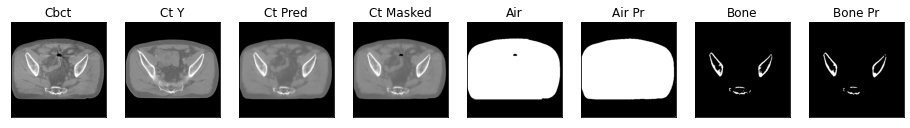

ssim score = 0.7610847353935242
psnr score = 20.896711349487305
snr score = 12.792729377746582
mae error = 0.038699980825185776
air dice score = 0.9946330369068996
bone dice score = 0.9154972544247179


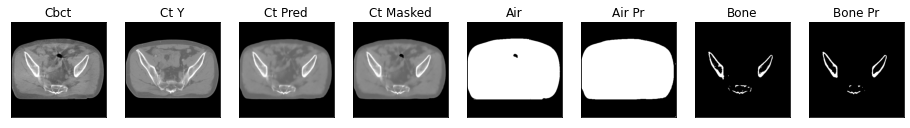

ssim score = 0.7495831251144409
psnr score = 20.721858978271484
snr score = 12.58808708190918
mae error = 0.039799440652132034
air dice score = 0.995260033934537
bone dice score = 0.9043869516322411


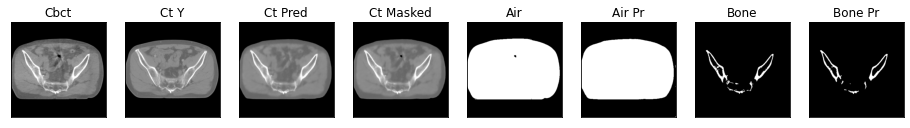

ssim score = 0.7486572861671448
psnr score = 20.944942474365234
snr score = 12.747795104980469
mae error = 0.03849088028073311
air dice score = 0.9953565063469191
bone dice score = 0.8973148023222599


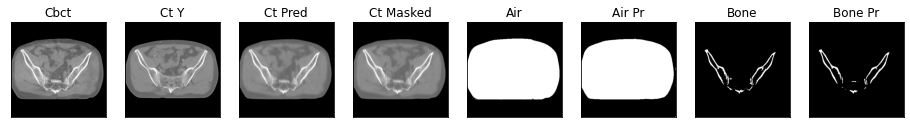

17it [00:42,  2.47s/it]

ssim score = 0.8522814512252808
psnr score = 23.30816650390625
snr score = 14.785558700561523
mae error = 0.025200413540005684
air dice score = 0.9926070415509634
bone dice score = 0.8864864864879134


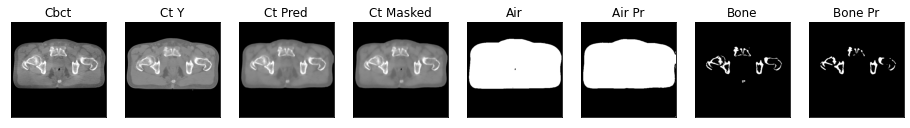

ssim score = 0.8551300764083862
psnr score = 23.497827529907227
snr score = 15.015231132507324
mae error = 0.024231290444731712
air dice score = 0.9921118947855061
bone dice score = 0.8693812797478929


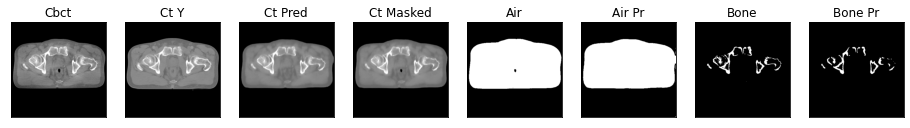

ssim score = 0.852932870388031
psnr score = 23.48393440246582
snr score = 15.009122848510742
mae error = 0.02514171227812767
air dice score = 0.9924285415608909
bone dice score = 0.84051904562801


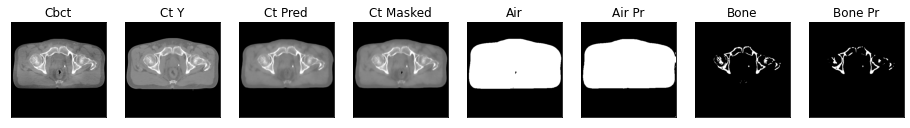

ssim score = 0.8582473993301392
psnr score = 23.773338317871094
snr score = 15.240108489990234
mae error = 0.023690572008490562
air dice score = 0.9927328518504713
bone dice score = 0.8468680528331781


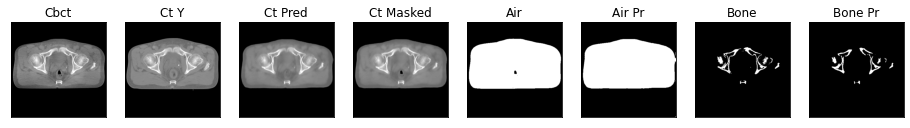

ssim score = 0.8609881401062012
psnr score = 23.78832244873047
snr score = 15.099469184875488
mae error = 0.02256903611123562
air dice score = 0.9928340719597439
bone dice score = 0.856082856703415


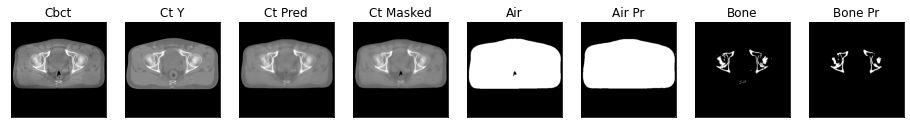

ssim score = 0.8654778003692627
psnr score = 23.89727020263672
snr score = 15.187614440917969
mae error = 0.02166963554918766
air dice score = 0.9930185794654408
bone dice score = 0.8851612903242271


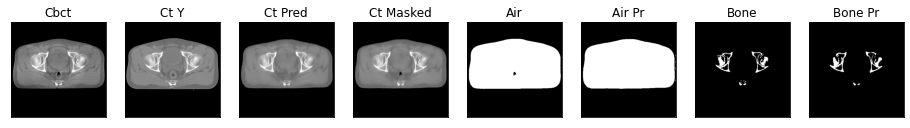

ssim score = 0.8662126064300537
psnr score = 23.851036071777344
snr score = 15.125750541687012
mae error = 0.02180314064025879
air dice score = 0.9926998473467099
bone dice score = 0.8934861615894117


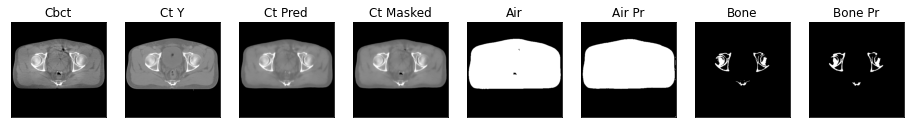

ssim score = 0.8620852828025818
psnr score = 23.447772979736328
snr score = 14.731851577758789
mae error = 0.022667014971375465
air dice score = 0.992145941310837
bone dice score = 0.8833761049346539


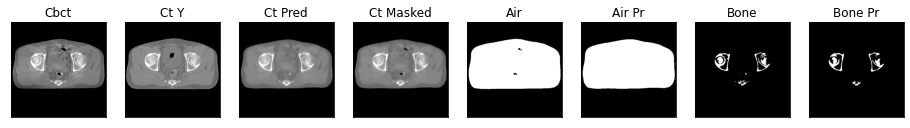

18it [00:45,  2.49s/it]

ssim score = 0.8604558110237122
psnr score = 23.57710075378418
snr score = 14.916959762573242
mae error = 0.023198287934064865
air dice score = 0.9933595708793681
bone dice score = 0.9197140500423465


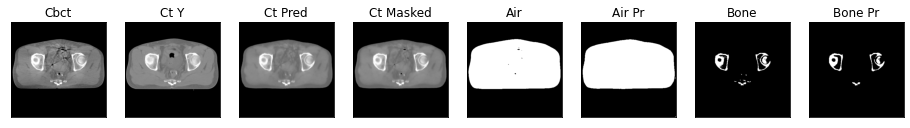

ssim score = 0.8585589528083801
psnr score = 23.16150665283203
snr score = 14.479434967041016
mae error = 0.023799359798431396
air dice score = 0.9929230534584055
bone dice score = 0.9228817143673639


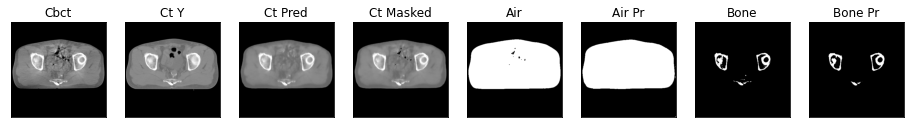

ssim score = 0.8575633764266968
psnr score = 22.576763153076172
snr score = 13.823917388916016
mae error = 0.024478502571582794
air dice score = 0.991336586262636
bone dice score = 0.8930292322535652


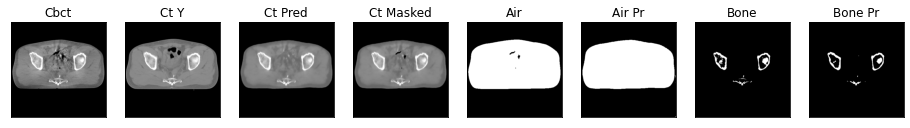

ssim score = 0.8578202128410339
psnr score = 22.930774688720703
snr score = 14.13403606414795
mae error = 0.023748202249407768
air dice score = 0.9934712643678211
bone dice score = 0.8938983050865441


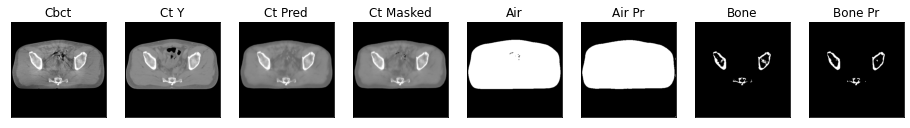

ssim score = 0.8601416349411011
psnr score = 23.279865264892578
snr score = 14.482029914855957
mae error = 0.023085465654730797
air dice score = 0.9928206862624579
bone dice score = 0.9138072566095254


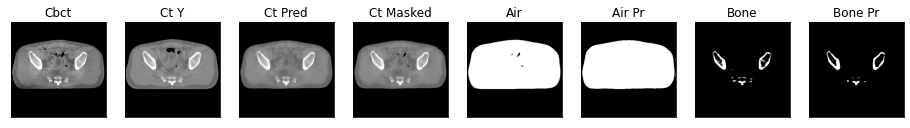

ssim score = 0.8586874008178711
psnr score = 23.717878341674805
snr score = 14.933399200439453
mae error = 0.022452672943472862
air dice score = 0.9922194890617951
bone dice score = 0.9227414330230103


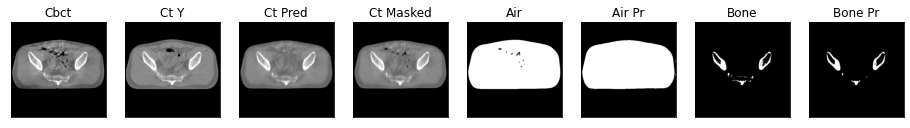

ssim score = 0.8550698161125183
psnr score = 23.705930709838867
snr score = 14.976655960083008
mae error = 0.022708240896463394
air dice score = 0.9899304425957848
bone dice score = 0.9259838415438365


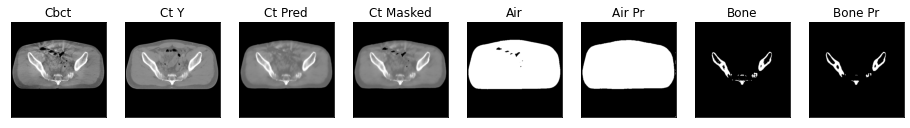

ssim score = 0.856501579284668
psnr score = 23.479907989501953
snr score = 14.770002365112305
mae error = 0.022992054000496864
air dice score = 0.991349373682259
bone dice score = 0.9178975382579122


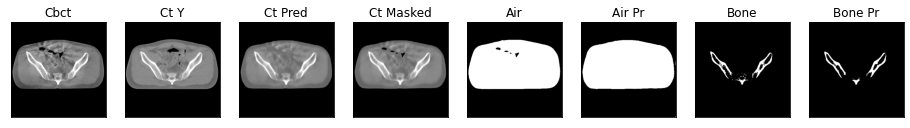

19it [00:47,  2.43s/it]

ssim score = 0.8583359718322754
psnr score = 23.007850646972656
snr score = 14.243207931518555
mae error = 0.023486020043492317
air dice score = 0.9913938274574996
bone dice score = 0.9065188858114843


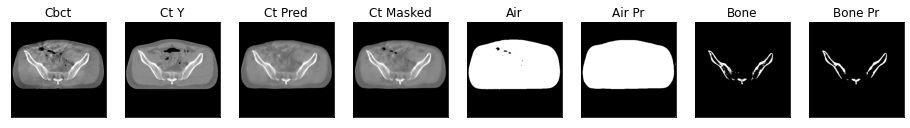

ssim score = 0.8590704798698425
psnr score = 23.05257797241211
snr score = 14.25158405303955
mae error = 0.023590562865138054
air dice score = 0.9933877627045034
bone dice score = 0.884113811501421


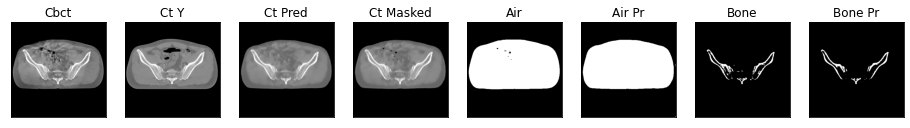

ssim score = 0.8626139760017395
psnr score = 23.04758071899414
snr score = 14.24665641784668
mae error = 0.023540237918496132
air dice score = 0.9926232247934327
bone dice score = 0.8821575660969555


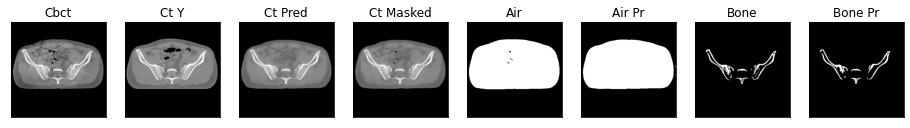

ssim score = 0.8639389276504517
psnr score = 23.43289566040039
snr score = 14.6305513381958
mae error = 0.02305172011256218
air dice score = 0.992355954104594
bone dice score = 0.8744412840325824


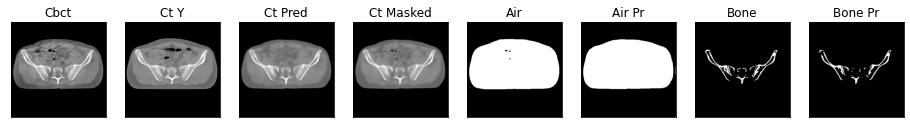

ssim score = 0.8560450077056885
psnr score = 23.135669708251953
snr score = 14.338363647460938
mae error = 0.024179210886359215
air dice score = 0.9913215852154843
bone dice score = 0.8730964467022486


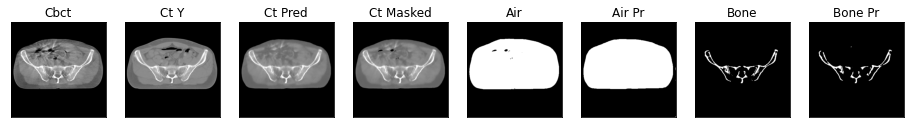

ssim score = 0.8535603284835815
psnr score = 23.001672744750977
snr score = 14.187093734741211
mae error = 0.024584943428635597
air dice score = 0.9903210409771365
bone dice score = 0.8687482730054055


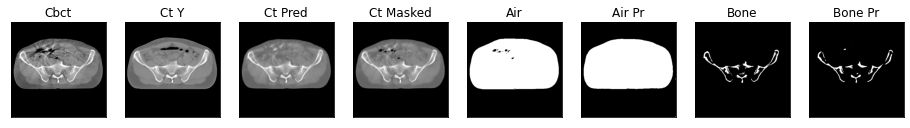

ssim score = 0.8512300848960876
psnr score = 22.684131622314453
snr score = 13.850927352905273
mae error = 0.025695206597447395
air dice score = 0.9903502165317342
bone dice score = 0.8523771998968692


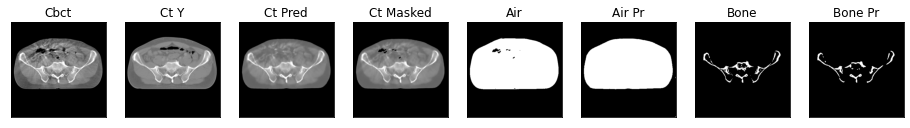

ssim score = 0.8422278165817261
psnr score = 22.3038387298584
snr score = 13.424697875976562
mae error = 0.02684604376554489
air dice score = 0.9895935010548274
bone dice score = 0.836344995516643


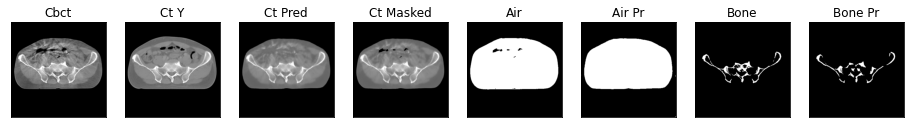

20it [00:49,  2.45s/it]

ssim score = 0.8368790745735168
psnr score = 22.32596206665039
snr score = 13.393022537231445
mae error = 0.02741195820271969
air dice score = 0.9883601398048517
bone dice score = 0.872277227724353


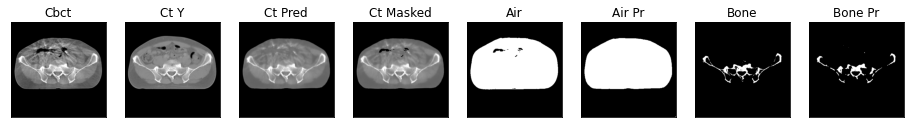

ssim score = 0.8326436281204224
psnr score = 22.090856552124023
snr score = 13.188379287719727
mae error = 0.02856788970530033
air dice score = 0.9873981902246854
bone dice score = 0.8841047721578267


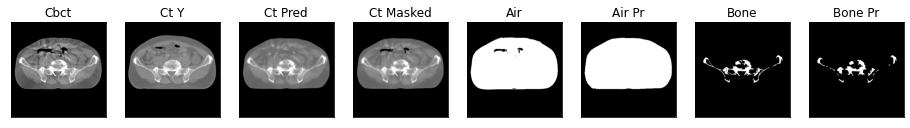

ssim score = 0.8285051584243774
psnr score = 21.69399642944336
snr score = 12.73629379272461
mae error = 0.029107550159096718
air dice score = 0.9881676083311575
bone dice score = 0.8649667127262283


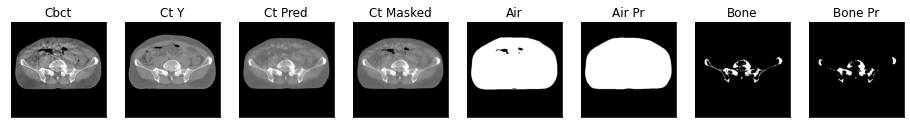

ssim score = 0.8359481692314148
psnr score = 22.258014678955078
snr score = 13.15278148651123
mae error = 0.027059396728873253
air dice score = 0.9885117909496586
bone dice score = 0.8923238145154267


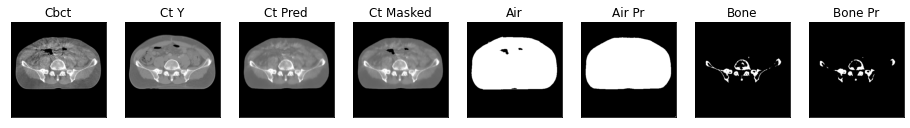

ssim score = 0.8827031850814819
psnr score = 26.389705657958984
snr score = 16.770618438720703
mae error = 0.01593916490674019
air dice score = 0.9934582547954367
bone dice score = 0.947225244832774


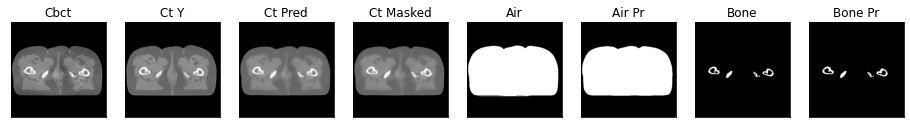

ssim score = 0.8822295069694519
psnr score = 26.523897171020508
snr score = 17.02582359313965
mae error = 0.01587878353893757
air dice score = 0.9933466498252259
bone dice score = 0.9512589512600772


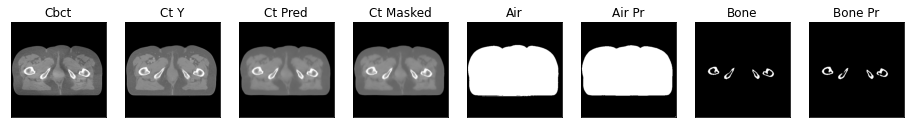

ssim score = 0.8763746023178101
psnr score = 26.30023956298828
snr score = 16.885080337524414
mae error = 0.016575966030359268
air dice score = 0.9931718431641802
bone dice score = 0.9322140608618633


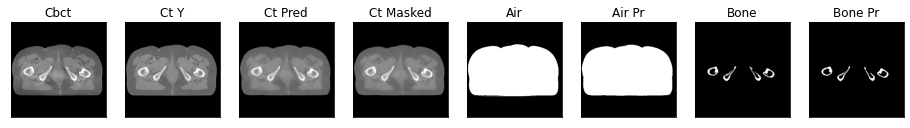

ssim score = 0.8750597238540649
psnr score = 26.325469970703125
snr score = 16.973756790161133
mae error = 0.016746344044804573
air dice score = 0.9933273795261689
bone dice score = 0.9344847005831709


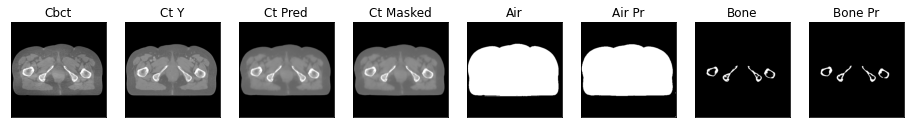

21it [00:52,  2.47s/it]

ssim score = 0.8734624981880188
psnr score = 26.051748275756836
snr score = 16.728496551513672
mae error = 0.017266670241951942
air dice score = 0.9932174680960462
bone dice score = 0.933072962898401


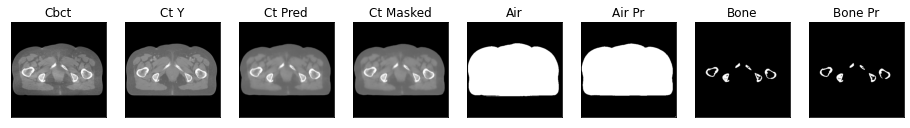

ssim score = 0.8731212019920349
psnr score = 25.844268798828125
snr score = 16.543970108032227
mae error = 0.017391839995980263
air dice score = 0.9929795163666881
bone dice score = 0.931628682602712


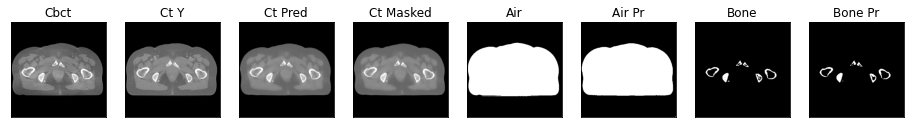

ssim score = 0.8694148659706116
psnr score = 25.70996856689453
snr score = 16.440994262695312
mae error = 0.01768406853079796
air dice score = 0.9928116686013448
bone dice score = 0.9269096904208296


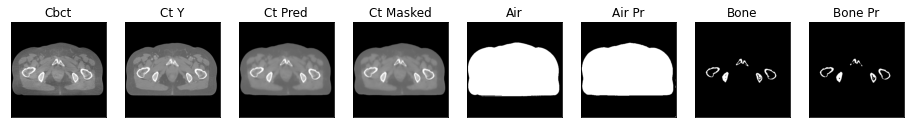

ssim score = 0.8711563944816589
psnr score = 25.76041030883789
snr score = 16.53980255126953
mae error = 0.0180579274892807
air dice score = 0.9933288715214107
bone dice score = 0.9209436340730967


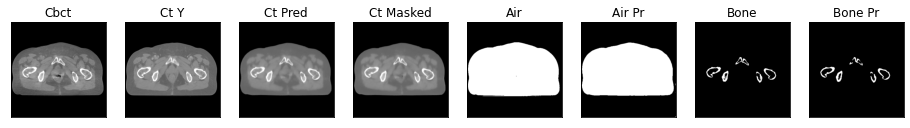

ssim score = 0.8717992305755615
psnr score = 25.715742111206055
snr score = 16.537879943847656
mae error = 0.017968961969017982
air dice score = 0.9919600377165702
bone dice score = 0.9221277305332312


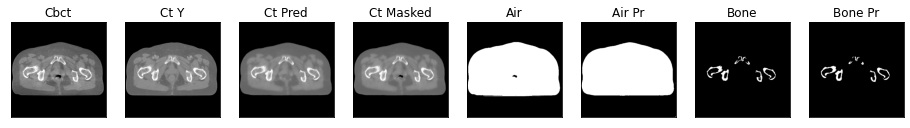

ssim score = 0.8720256686210632
psnr score = 25.986602783203125
snr score = 16.896440505981445
mae error = 0.017773937433958054
air dice score = 0.991864421410029
bone dice score = 0.9001319841633652


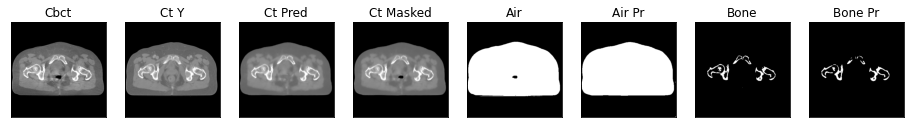

ssim score = 0.8740680813789368
psnr score = 26.33844757080078
snr score = 17.361562728881836
mae error = 0.017816057428717613
air dice score = 0.9924650469860242
bone dice score = 0.9090031378239318


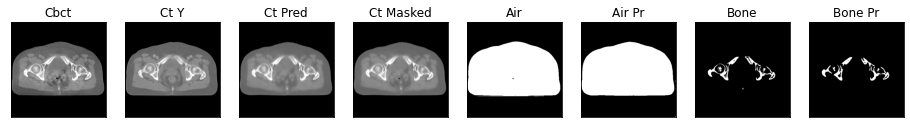

ssim score = 0.8777291774749756
psnr score = 26.681957244873047
snr score = 17.576519012451172
mae error = 0.016938332468271255
air dice score = 0.9908473871691471
bone dice score = 0.8815282159151502


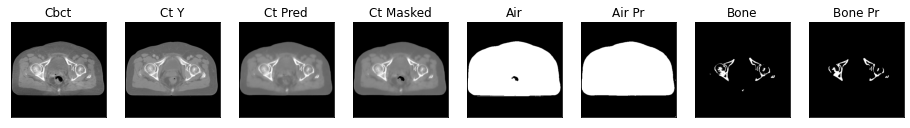

22it [00:54,  2.42s/it]

ssim score = 0.8807404637336731
psnr score = 27.124483108520508
snr score = 17.909624099731445
mae error = 0.01645580865442753
air dice score = 0.9907112773245113
bone dice score = 0.872777017786344


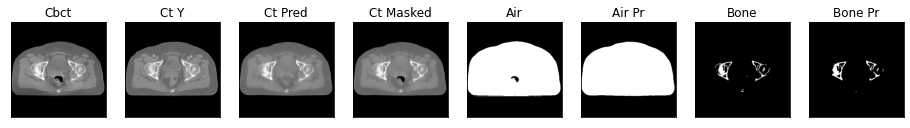

ssim score = 0.8814681172370911
psnr score = 26.807098388671875
snr score = 17.56511116027832
mae error = 0.017289241775870323
air dice score = 0.9907886669233358
bone dice score = 0.8903248340920307


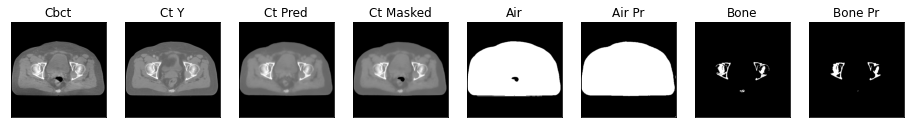

ssim score = 0.8823554515838623
psnr score = 26.580280303955078
snr score = 17.330289840698242
mae error = 0.018201543018221855
air dice score = 0.9928743448080515
bone dice score = 0.89946200403666


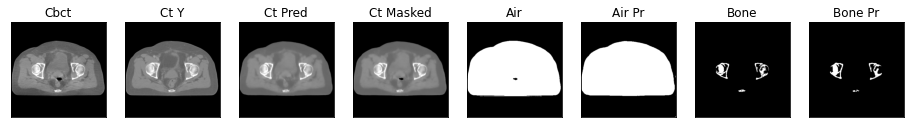

ssim score = 0.8811927437782288
psnr score = 26.796226501464844
snr score = 17.580461502075195
mae error = 0.017097480595111847
air dice score = 0.9939163177564884
bone dice score = 0.9248826291091568


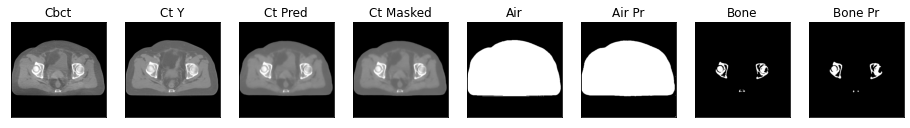

ssim score = 0.8763931393623352
psnr score = 26.444894790649414
snr score = 17.280624389648438
mae error = 0.01745651476085186
air dice score = 0.994183775942874
bone dice score = 0.9434667497283372


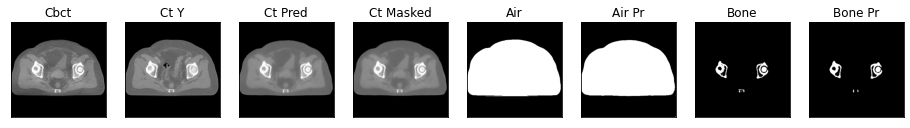

ssim score = 0.8662608861923218
psnr score = 25.467811584472656
snr score = 16.341096878051758
mae error = 0.01898576132953167
air dice score = 0.9947465195692182
bone dice score = 0.9479669193668511


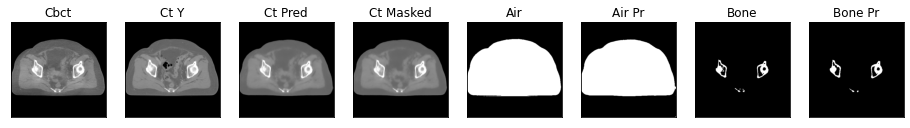

ssim score = 0.8542500734329224
psnr score = 24.062454223632812
snr score = 14.863304138183594
mae error = 0.021415380761027336
air dice score = 0.9937489718703777
bone dice score = 0.9349665924290653


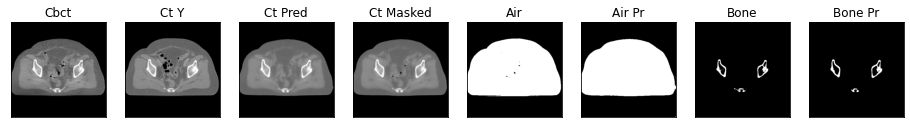

ssim score = 0.8507236242294312
psnr score = 24.073591232299805
snr score = 14.856447219848633
mae error = 0.021952006965875626
air dice score = 0.9925780798247634
bone dice score = 0.9393665158384759


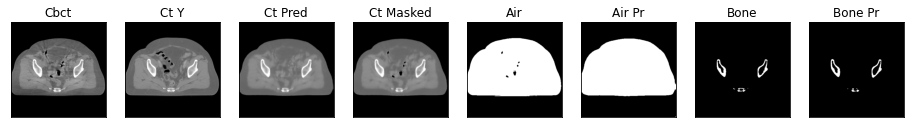

23it [00:57,  2.45s/it]

ssim score = 0.8489798307418823
psnr score = 24.412508010864258
snr score = 15.260278701782227
mae error = 0.02186616323888302
air dice score = 0.9931741764202543
bone dice score = 0.9329268292697533


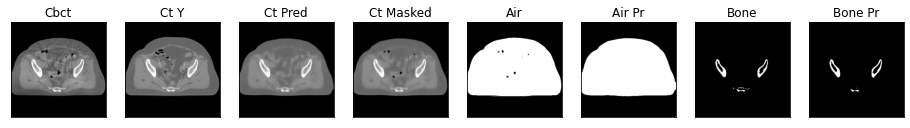

ssim score = 0.8501625657081604
psnr score = 24.32283592224121
snr score = 15.225698471069336
mae error = 0.0219661183655262
air dice score = 0.9937743138733418
bone dice score = 0.9417007055339454


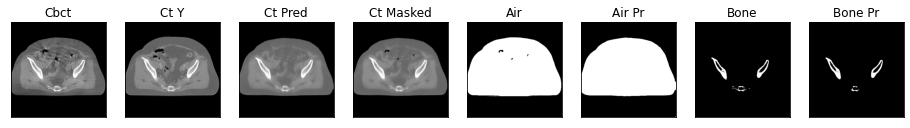

ssim score = 0.8476434946060181
psnr score = 23.933515548706055
snr score = 14.900812149047852
mae error = 0.023047475144267082
air dice score = 0.9936256033855758
bone dice score = 0.9382830626459663


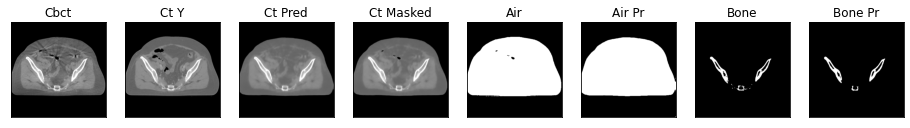

ssim score = 0.8476018309593201
psnr score = 23.978992462158203
snr score = 15.019144058227539
mae error = 0.023472702130675316
air dice score = 0.9929998359849153
bone dice score = 0.9080459770128493


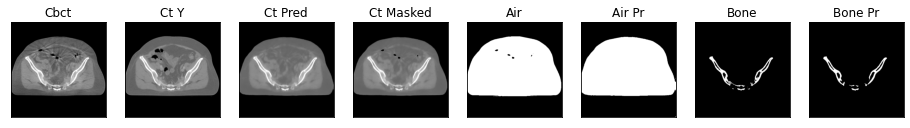

ssim score = 0.8474164009094238
psnr score = 24.15237808227539
snr score = 15.188244819641113
mae error = 0.02330394648015499
air dice score = 0.9934065076598997
bone dice score = 0.9039715471264972


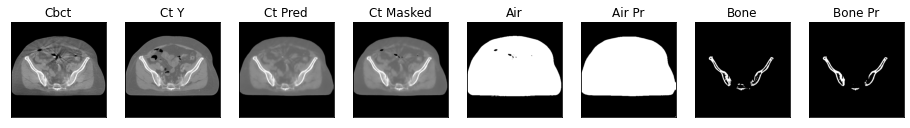

ssim score = 0.8380901217460632
psnr score = 23.58643341064453
snr score = 14.600120544433594
mae error = 0.024595262482762337
air dice score = 0.9922692896400781
bone dice score = 0.8918454935637791


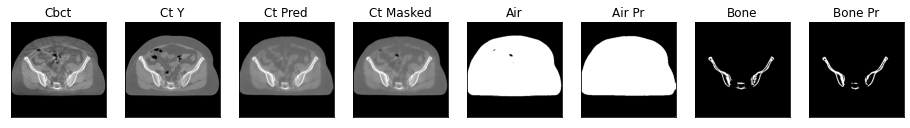

ssim score = 0.8379851579666138
psnr score = 23.912851333618164
snr score = 14.938173294067383
mae error = 0.023811347782611847
air dice score = 0.9924401269597047
bone dice score = 0.9044051543316691


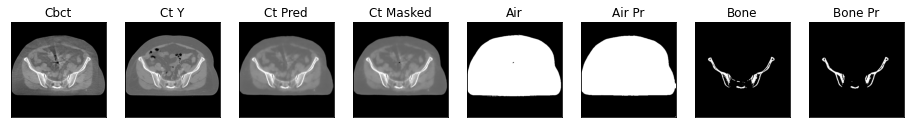

24it [00:59,  2.48s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.25it/s]


(0.8557359799742699,
 24.246146996815998,
 15.260717233022055,
 0.02330711348137508,
 0.9918491873474062,
 0.9120253108617424,
 0.5)

In [ ]:
# masked
eval_epoch(model, discriminator, testloader, device)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)